
# Float vertical position control, ensta prototype


---

## Equations of motion

For basics about float dynamics go [here](https://github.com/apatlpo/cognac/blob/master/instrum/float_dynamics_basics.ipynb)

We assume now that the float has the ability to control its volume between two bounds $V+v_{min}$ and $V+v_{max}$
with a precision $dv$.

---

## Control

We control the float vertical position with sliding modes, see [this notebook](https://github.com/apatlpo/cognac/blob/master/instrum/zcontrol_realistic.ipynb) for more details about control.


In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
from scipy.interpolate import interp1d
import time
from copy import deepcopy

from matplotlib import animation, rc
from IPython.display import HTML

from float_lib import *

WOA water profile at lon=-50, lat=40


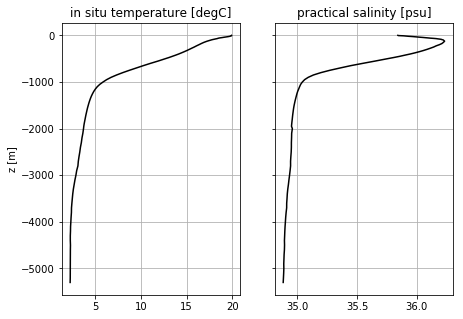

In [2]:
# select a water profile
w = waterp(lon=-50.,lat=40.)
print(w)
#w.show_on_map()

--- 
## Instantiate the float object

In [3]:
# Init now active control of the vertical position

#
z=np.arange(-100.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = autonomous_float(model='ENSTA')

# compute compressibility
gamma=compute_gamma(f.r,.005,material='polycarbonat')
print('Float compressibility = %e /dbar \n' %(gamma))
f.gamma=gamma

# adjust mass to be at equilibrium at -25m
iz = np.argmin(np.abs(z+25))
f.adjust_m(p[iz],temp[iz],rho_w[iz])

# set vmax such that the float has an extra buoyancy at the surface equal
# to a cylinder ot 2cm radius and height of 10cm (antenna casing)
iz = np.argmin(np.abs(z+0.))
vmax = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz]) + .1*np.pi*.02**2
# use d_max to prescribe piston max course
dmax = .07

#
f.init_piston(d_max=dmax,vol_max=vmax,vol=vmax)
print(f)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

Float compressibility = 9.300000e-05 /dbar 

131.8 g were added to the float in order to be at equilibrium at 25 dbar 

Piston max displacement set from max volume
Float parameters: 
  L     = 0.50 m      - float length
  r     = 0.06 m      - float radius
  m     = 5.79 kg     - float mass
  V     = 5.65e+03 cm^3   - float volume
  rho_cte     = 1.02e+09 kg.cm^3   - float constant density
  gamma = 9.30e-05 /dbar  - mechanical compressibility
  alpha = 0.00e+00 /degC  - thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 25.00 mm        - piston radius
  phi   = 0.00 rad       - present angle of rotation
  d     = 0.00 mm        - present piston displacement
  vol   = 114.46 cm^3      - present volume addition
  lead  = 1.75 cm        - screw lead
  tick_per_t

In [4]:
rho_eq = rho_w[iz]
temp_eq = temp[iz]
p_eq=20
f.piston_update_vol(f.piston.vol_max)
print(rho_eq - f.rho(p=p_eq, temp=temp_eq))
f.piston_update_vol(f.piston.vol_min)
print(rho_eq - f.rho(p=p_eq, temp=temp_eq))

20.597707653301427
-3.9710755106480065


In [5]:
# adjust piston to be at equilibrium 20m
iz = np.argmin(np.abs(z+20.))
vmax = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) ) # check

# compute float vertical displacement associated with 1mm piston displacement
f.piston.update_d(f.piston.d+.001)
f.piston_update_vol()
print('z equilibrium after 1 mm piston displacement = %.1fm' %(f.z4equilibrium(w) ) )

Piston reset : vol=-2.2e+00 cm^3  
z equilibrium = -20.0m
z equilibrium after 1 mm piston displacement = -24.4m


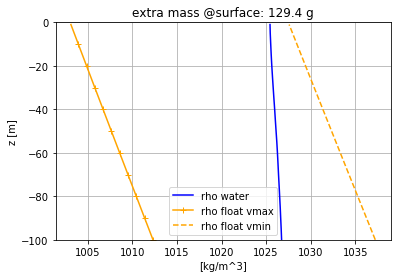

In [6]:
# show densities
plot_float_density(z, f, w)

---

## From the surface down to a target level

In [7]:
# we start by constructing a trajectory that can be followed by the float
z_target = descent(3600, -25., f, w)

Acceleration and velocity bounds (zmin=-500m,zmax=0m):
fmax/m=2.2e-01 m^2/s, fmin/m= -4.5e-01 m^2/s, wmax= 386.3 cm/s
For accelerations, equivalent speed reached in 1min:
  fmax 1.3e+03 cm/s, fmin/m= -2.7e+03 cm/s


In [8]:
# time step float with control
#control = {'tau': 10.,'dz_nochattering': 1., 'mode': 'sliding', 'd3y_ctrl': afmax/f.m/1.}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 0.02}
control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'kalman_feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}
#
f.time_step(w,T=300., dt_step=.1, dt_store=1., z=-10., w=0., v=f.piston.vol_max,
             usepiston=True, z_target=z_target, ctrl=control)

v 0.00011446191940347092
 ctrl: tau = 2.0
 ctrl: dz_nochattering = 1.0
 ctrl: mode = feedback
 ctrl: Lv = 0.5
 ctrl: dt_ctrl = 0.1
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 1.0
Start time stepping for 5 min ...
(2, 4) (2, 2) (4, 4)
K [[0.  0. ]
 [0.5 0. ]
 [0.  0.5]
 [0.  0. ]]
ytilde [-9.95298794e-08 -1.78438856e-04]
x_hat [1.59791667e-01 9.99999995e+00 2.52424916e-05 1.00000000e-06]
u 0
z -10.0
v 0.00011446191940347092
gamma [[1.00005689e-02 9.10178550e-07 0.00000000e+00 0.00000000e+00]
 [9.10178550e-07 1.50000000e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00364071 0.        ]
 [0.6        0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-0.08258545 -0.00015279]
x_hat [ 3.08430577e-01  1.01099397e+01 -7.82998913e-05  1.00000000e-06]
u -0.00010061792596608913
z -9.917415965957982
v 5.0550143857003494e-05
gamma [[2.

(2, 4) (2, 2) (4, 4)
K [[0.00373771 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.37642585e+00  1.21572034e-05]
x_hat [ 8.11728511e-01  9.15414119e+00 -2.10170725e-04  1.00000000e-06]
u -6.1347502801223e-06
z -7.82707449588185
v -1.4005155127738504e-05
gamma [[3.24867945e-01 9.77759282e-07 0.00000000e+00 0.00000000e+00]
 [9.77759282e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00373471 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.36309177e+00  1.84433038e-05]
x_hat [ 8.17020640e-01  9.11834191e+00 -2.15512130e-04  1.00000000e-06]
u -5.694419249608781e-06
z -7.791049059151354
v -1.4005155127738504e-05
gamma [[3.25641664e-01 9.76917180e-07 0.00000000e+00 0.00000000e+00]
 [9.76917180e-07 1.61803399e-04 0.00000000e+00 0.00000000

(2, 4) (2, 2) (4, 4)
K [[0.00371833 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.18355482e+00  1.15412694e-05]
x_hat [ 8.35239612e-01  1.01581911e+01 -2.02583823e-04  1.00000000e-06]
u 1.319579947567169e-06
z -8.875829347461586
v -1.4005155127738504e-05
gamma [[3.29298884e-01 9.73396169e-07 0.00000000e+00 0.00000000e+00]
 [9.73396169e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00371804 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.18151946e+00  1.01285757e-05]
x_hat [ 8.35884268e-01  1.02588186e+01 -2.01081851e-04  1.00000000e-06]
u 1.3081062528080076e-06
z -8.97667329652733
v -1.4005155127738504e-05
gamma [[3.29382872e-01 9.73306975e-07 0.00000000e+00 0.00000000e+00]
 [9.73306975e-07 1.61803399e-04 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.00370724 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.18834344e+00 -1.98059864e-05]
x_hat [ 8.54557923e-01  1.24547854e+01 -1.71824429e-04  1.00000000e-06]
u 1.9498817214112623e-06
z -11.151668395688857
v -1.4005155127738504e-05
gamma [[3.32321286e-01 9.70418951e-07 0.00000000e+00 0.00000000e+00]
 [9.70418951e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00370667 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.18920321e+00 -2.16930145e-05]
x_hat [ 8.55496100e-01  1.25699673e+01 -1.70244492e-04  1.00000000e-06]
u 1.9951520497792495e-06
z -11.26558216703863
v -1.4005155127738504e-05
gamma [[3.32476173e-01 9.70272304e-07 0.00000000e+00 0.00000000e+00]
 [9.70272304e-07 1.61803399e-04 0.00000000e+00 0.0000

(2, 4) (2, 2) (4, 4)
K [[0.0036963  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.20426409e+00 -5.60784843e-05]
x_hat [ 8.72704022e-01  1.49573294e+01 -1.35447020e-04  1.00000000e-06]
u 2.9176376578951795e-06
z -13.629914995640151
v -1.4005155127738504e-05
gamma [[3.35377982e-01 9.67577367e-07 0.00000000e+00 0.00000000e+00]
 [9.67577367e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00369582 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.20492425e+00 -5.73304188e-05]
x_hat [ 8.73520802e-01  1.50808961e+01 -1.33580230e-04  1.00000000e-06]
u 2.9641231968960986e-06
z -13.752407976345012
v -1.4005155127738504e-05
gamma [[3.35518664e-01 9.67448659e-07 0.00000000e+00 0.00000000e+00]
 [9.67448659e-07 1.61803399e-04 0.00000000e+00 0.000

(2, 4) (2, 2) (4, 4)
K [[0.00368628 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.21788954e+00 -9.58099279e-05]
x_hat [ 8.89568296e-01  1.76369467e+01 -9.43196989e-05  1.00000000e-06]
u 3.888723612132676e-06
z -16.28746052370423
v -1.4005155127738504e-05
gamma [[3.38313948e-01 9.64959186e-07 0.00000000e+00 0.00000000e+00]
 [9.64959186e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00368582 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.21850746e+00 -9.89077884e-05]
x_hat [ 8.90371532e-01  1.77689448e+01 -9.22777708e-05  1.00000000e-06]
u 3.935073141185343e-06
z -16.418438356235356
v -1.4005155127738504e-05
gamma [[3.38452906e-01 9.64837965e-07 0.00000000e+00 0.00000000e+00]
 [9.64837965e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00367631 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.23163461e+00 -1.41020468e-04]
x_hat [ 9.06571805e-01  2.04934247e+01 -4.98551372e-05  1.00000000e-06]
u 4.883795022935145e-06
z -19.1217595603563
v -1.4005155127738504e-05
gamma [[3.41368214e-01 9.62344503e-07 0.00000000e+00 0.00000000e+00]
 [9.62344503e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00367583 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.23231248e+00 -1.42598872e-04]
x_hat [ 9.07384566e-01  2.06338557e+01 -4.76516142e-05  1.00000000e-06]
u 4.932937492789467e-06
z -19.261112772472742
v -1.4005155127738504e-05
gamma [[3.41518930e-01 9.62218153e-07 0.00000000e+00 0.00000000e+00]
 [9.62218153e-07 1.61803399e-04 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.00366722 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.24459568e+00 -1.84415031e-04]
x_hat [ 9.22071348e-01  2.32292558e+01 -6.67223979e-06  1.00000000e-06]
u 5.890257084210414e-06
z -21.837161861817794
v -1.4005155127738504e-05
gamma [[3.44263346e-01 9.59966760e-07 0.00000000e+00 0.00000000e+00]
 [9.59966760e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00366675 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.24526638e+00 -1.86645262e-04]
x_hat [ 9.22867697e-01  2.33771441e+01 -4.28972878e-06  1.00000000e-06]
u 5.954995616546032e-06
z -21.983989843461853
v -1.4005155127738504e-05
gamma [[3.44416493e-01 9.59843546e-07 0.00000000e+00 0.00000000e+00]
 [9.59843546e-07 1.61803399e-04 0.00000000e+00 0.00000

(2, 4) (2, 2) (4, 4)
K [[0.00365509 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.27581790e+00 -2.37474355e-04]
x_hat [9.43415687e-01 2.68185313e+01 4.77374657e-05 1.00000000e-06]
u 6.5268648053931015e-06
z -25.393564086794186
v -1.2580791792958049e-05
gamma [[3.48337978e-01 9.56754099e-07 0.00000000e+00 0.00000000e+00]
 [9.56754099e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00365448 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.27698139e+00 -2.38588049e-04]
x_hat [9.44547717e-01 2.69680624e+01 4.96976347e-05 1.00000000e-06]
u 6.5268648053931015e-06
z -25.54154970755075
v -1.2580791792958049e-05
gamma [[3.48554871e-01 9.56585137e-07 0.00000000e+00 0.00000000e+00]
 [9.56585137e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00

(2, 4) (2, 2) (4, 4)
K [[0.00363713 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.66104106e+00 -1.99418872e-04]
x_hat [9.80850143e-01 2.79981716e+01 2.16045695e-05 1.00000000e-06]
u -2.685604881994658e-06
z -26.393398972409802
v 7.111576035491869e-06
gamma [[3.55146063e-01 9.51531179e-07 0.00000000e+00 0.00000000e+00]
 [9.51531179e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00363453 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.67903569e+00 -1.93465776e-04]
x_hat [9.85258785e-01 2.79352181e+01 1.51041274e-05 1.00000000e-06]
u -2.797409430685826e-06
z -26.319134371373558
v 7.111576035491869e-06
gamma [[3.56109051e-01 9.50856895e-07 0.00000000e+00 0.00000000e+00]
 [9.50856895e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 

(2, 4) (2, 2) (4, 4)
K [[0.00359359 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.85687630e+00 -6.00019962e-05]
x_hat [ 1.06378395e+00  2.56034033e+01 -1.31378252e-04  1.00000000e-06]
u -6.184504455564422e-06
z -23.850072812566463
v -5.474266778226658e-06
gamma [[3.72639077e-01 9.40547024e-07 0.00000000e+00 0.00000000e+00]
 [9.40547024e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00359257 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.83883614e+00 -5.34928928e-05]
x_hat [ 1.06786220e+00  2.55241179e+01 -1.39578999e-04  1.00000000e-06]
u -7.1768650855110515e-06
z -23.76456721896321
v -6.902921318579844e-06
gamma [[3.75212398e-01 9.38309733e-07 0.00000000e+00 0.00000000e+00]
 [9.38309733e-07 1.61803399e-04 0.00000000e+00 0.00000

(2, 4) (2, 2) (4, 4)
K [[0.00356966 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.60105077e+00 -3.96004367e-05]
x_hat [ 1.09179377e+00  2.62593538e+01 -1.44015351e-04  1.00000000e-06]
u 3.0785526572336135e-06
z -24.561539694195414
v -6.902921318579844e-06
gamma [[3.83828244e-01 9.34582253e-07 0.00000000e+00 0.00000000e+00]
 [9.34582253e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00356979 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.59739471e+00 -4.18942565e-05]
x_hat [ 1.09167726e+00  2.63582010e+01 -1.41738675e-04  1.00000000e-06]
u 3.0785526572336135e-06
z -24.66195731565437
v -6.902921318579844e-06
gamma [[3.83768005e-01 9.34608393e-07 0.00000000e+00 0.00000000e+00]
 [9.34608393e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00358122 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.76050280e+00 -8.98415831e-05]
x_hat [ 1.07293010e+00  2.81226557e+01 -8.41179373e-05  1.00000000e-06]
u -9.971899051244076e-07
z -26.384681219363813
v 7.020987865118233e-06
gamma [[3.78280320e-01 9.37492223e-07 0.00000000e+00 0.00000000e+00]
 [9.37492223e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.0035809  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.77694840e+00 -8.73927542e-05]
x_hat [ 1.07455456e+00  2.80910082e+01 -8.74926404e-05  1.00000000e-06]
u -1.7019616435729871e-06
z -26.345706344640185
v 7.020987865118233e-06
gamma [[3.78501382e-01 9.37315952e-07 0.00000000e+00 0.00000000e+00]
 [9.37315952e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00356031 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.96177568e+00  5.63649774e-06]
x_hat [ 1.11028865e+00  2.59433969e+01 -1.80663578e-04  1.00000000e-06]
u -3.2643978039437643e-06
z -24.091373615587475
v 7.020987865118233e-06
gamma [[3.88766050e-01 9.32002831e-07 0.00000000e+00 0.00000000e+00]
 [9.32002831e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00355993 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.96374557e+00  5.44939494e-06]
x_hat [ 1.11090004e+00  2.58330332e+01 -2.04219168e-04  1.00000000e-06]
u -2.3659893510621802e-05
z -23.979651719094075
v 4.654998514056052e-06
gamma [[3.88953258e-01 9.31916954e-07 0.00000000e+00 0.00000000e+00]
 [9.31916954e-07 1.61803399e-04 0.00000000e+00 0.00000

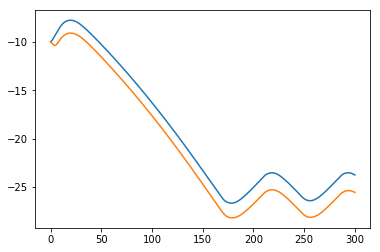

In [9]:
fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.log.t,f.log.z)
x_hat = np.array(f.x_kalman)
ax.plot(f.t_kalman,-x_hat[:,1])

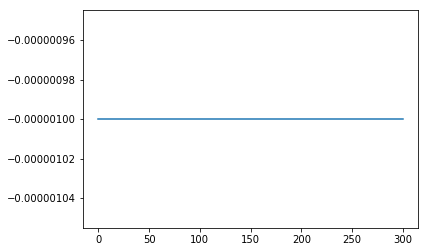

In [10]:
fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.t_kalman,-x_hat[:,3])

In [11]:
x_hat.shape

(302, 4)

Extrapolated energy conssumption: 0.0 Wh/day = 0.2 Wh/30day


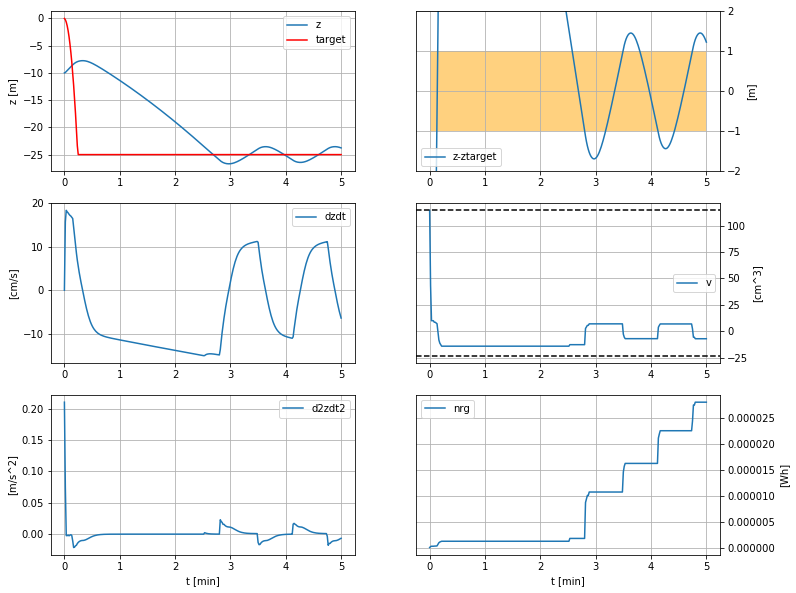

In [12]:
# plot log
plot_log(f,z_target=z_target)

---

## Oscillations around a fixed level

In [13]:
z_target = lambda t: -25+10.*np.sin(2.*np.pi/600.*t)

In [14]:
f.time_step(w,T=1800., dt_step=.1, dt_store=1.,
            usepiston=True, z_target=z_target, ctrl=control)

v None
 ctrl: tau = 2.0
 ctrl: dz_nochattering = 1.0
 ctrl: mode = feedback
 ctrl: Lv = 0.5
 ctrl: dt_ctrl = 0.1
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 1.0
Start time stepping for 30 min ...
(2, 4) (2, 2) (4, 4)
K [[0.  0. ]
 [0.5 0. ]
 [0.  0.5]
 [0.  0. ]]
ytilde [ 1.10113439e-06 -1.78401968e-04]
x_hat [ 5.77231663e-01  2.38445150e+01 -9.61658105e-05  0.00000000e+00]
u 0
z -23.779611932489416
v -6.9648263099077926e-06
gamma [[1.00106254e-02 9.10178550e-07 0.00000000e+00 0.00000000e+00]
 [9.10178550e-07 1.50000000e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00364071 0.        ]
 [0.6        0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [ 3.02308445e-03 -8.97647736e-05]
x_hat [ 9.31491659e-01  2.44235715e+01 -9.49012531e-05  0.00000000e+00]
u 2.982700599806072e-06
z -23.847539948320545
v -6.9648263099077926e-06


(2, 4) (2, 2) (4, 4)
K [[0.00361005 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.65173950e+00 -1.33484006e-04]
x_hat [ 1.01797826e+00  2.68636928e+01 -3.98742911e-05  0.00000000e+00]
u 2.358558624003393e-06
z -25.21995379964329
v 5.474077656009128e-06
gamma [[3.65111503e-01 9.45337086e-07 0.00000000e+00 0.00000000e+00]
 [9.45337086e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00361087 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.66364207e+00 -1.34049829e-04]
x_hat [ 1.01786521e+00  2.68474766e+01 -4.09360929e-05  0.00000000e+00]
u 1.5039796706529907e-06
z -25.20005091934295
v 5.474077656009128e-06
gamma [[3.64866809e-01 9.45440246e-07 0.00000000e+00 0.00000000e+00]
 [9.45440246e-07 1.61803399e-04 0.00000000e+00 0.00000000e+

(2, 4) (2, 2) (4, 4)
K [[0.00360187 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.82094574e+00 -8.14768914e-05]
x_hat [ 1.03498762e+00  2.54113284e+01 -9.46161986e-05  0.00000000e+00]
u -8.458591406711915e-07
z -23.687607138762207
v 5.474077656009128e-06
gamma [[3.68786001e-01 9.42937677e-07 0.00000000e+00 0.00000000e+00]
 [9.42937677e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.0036017  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.82284043e+00 -7.91950251e-05]
x_hat [ 1.03519718e+00  2.53131733e+01 -9.70015112e-05  0.00000000e+00]
u -8.694797724291224e-07
z -23.588487979650317
v 5.474077656009128e-06
gamma [[3.68850337e-01 9.42902753e-07 0.00000000e+00 0.00000000e+00]
 [9.42902753e-07 1.61803399e-04 0.00000000e+00 0.0000000

 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00360107 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.83890291e+00 -3.93048257e-05]
x_hat [ 1.03584318e+00  2.35530875e+01 -1.36268786e-04  0.00000000e+00]
u -1.5522107446343296e-06
z -21.82142985243666
v 5.474077656009128e-06
gamma [[3.69094549e-01 9.42777711e-07 0.00000000e+00 0.00000000e+00]
 [9.42777711e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00360109 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.83948755e+00 -3.66717484e-05]
x_hat [ 1.03579525e+00  2.34454407e+01 -1.38570041e-04  0.00000000e+00]
u -1.5993392744007445e-06
z -21.713596935697023
v 5.474077656009128e-06
gamma [[3.69085363e-01 9.42783115e-07 0.00000000e+00 0.00000

(2, 4) (2, 2) (4, 4)
K [[0.00360194 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.85157384e+00  1.69396934e-05]
x_hat [ 1.03427997e+00  2.08603843e+01 -1.93509607e-04  0.00000000e+00]
u -2.8536469500672124e-06
z -19.125500568420424
v 5.474077656009128e-06
gamma [[3.68712959e-01 9.43008999e-07 0.00000000e+00 0.00000000e+00]
 [9.43008999e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00360197 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.85211349e+00  2.06511548e-05]
x_hat [ 1.03423369e+00  2.07433239e+01 -1.96037196e-04  0.00000000e+00]
u -2.922862846211613e-06
z -19.008270965364225
v 5.474077656009128e-06
gamma [[3.68702758e-01 9.43013520e-07 0.00000000e+00 0.00000000e+00]
 [9.43013520e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00359932 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.87334011e+00  8.52575061e-05]
x_hat [ 1.03941450e+00  1.80765624e+01 -2.61173353e-04  0.00000000e+00]
u -4.533221938612053e-06
z -16.32850959831839
v 5.474077656009128e-06
gamma [[3.69896342e-01 9.42275060e-07 0.00000000e+00 0.00000000e+00]
 [9.42275060e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00359917 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.87444193e+00  8.70714520e-05]
x_hat [ 1.03954975e+00  1.79507617e+01 -2.64039983e-04  0.00000000e+00]
u -4.533221938612053e-06
z -16.202120290483606
v 5.474077656009128e-06
gamma [[3.69945244e-01 9.42252239e-07 0.00000000e+00 0.00000000e+00]
 [9.42252239e-07 1.61803399e-04 0.00000000e+00 0.00000000

(2, 4) (2, 2) (4, 4)
K [[0.00359609 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.72707843e+00  1.35639753e-04]
x_hat [ 1.04802707e+00  1.55213027e+01 -3.26493537e-04  0.00000000e+00]
u -4.537368626002801e-06
z -13.821461680467579
v -1.108702547823296e-05
gamma [[3.71525956e-01 9.41187502e-07 0.00000000e+00 0.00000000e+00]
 [9.41187502e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00359502 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.71206914e+00  1.36692136e-04]
x_hat [ 1.04929871e+00  1.55050579e+01 -3.27559794e-04  0.00000000e+00]
u -3.6826133121282824e-06
z -13.809231927896592
v -1.108702547823296e-05
gamma [[3.71960200e-01 9.40950364e-07 0.00000000e+00 0.00000000e+00]
 [9.40950364e-07 1.61803399e-04 0.00000000e+00 0.0000

(2, 4) (2, 2) (4, 4)
K [[0.00361368 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.46675391e+00  5.87796055e-05]
x_hat [ 1.01124568e+00  1.69072559e+01 -2.45565871e-04  0.00000000e+00]
u 2.5113074764381333e-06
z -15.339815611854325
v -1.108702547823296e-05
gamma [[3.63604060e-01 9.46269178e-07 0.00000000e+00 0.00000000e+00]
 [9.46269178e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00361443 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.46302265e+00  5.51764935e-05]
x_hat [ 1.01007649e+00  1.70090159e+01 -2.41998457e-04  0.00000000e+00]
u 2.5113074764381333e-06
z -15.444232499209296
v -1.108702547823296e-05
gamma [[3.63307922e-01 9.46452164e-07 0.00000000e+00 0.00000000e+00]
 [9.46452164e-07 1.61803399e-04 0.00000000e+00 0.00000

 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00364523 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.63546691e+00 -5.63158954e-06]
x_hat [ 9.61533241e-01  1.78243130e+01 -1.74253985e-04  0.00000000e+00]
u -3.034762839792599e-06
z -16.245754469503893
v 2.715307123079481e-06
gamma [[3.51861406e-01 9.54087917e-07 0.00000000e+00 0.00000000e+00]
 [9.54087917e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00364429 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.64974120e+00 -1.81674371e-07]
x_hat [ 9.63022969e-01  1.77602380e+01 -1.77292225e-04  0.00000000e+00]
u -3.034762839792599e-06
z -16.174571498257627
v 2.715307123079481e-06
gamma [[3.52202752e-01 9.53828500e-07 0.00000000e+00 0.000000

 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00362323 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.59517956e+00  6.32404381e-05]
x_hat [ 9.98965480e-01  1.60541119e+01 -2.52753790e-04  0.00000000e+00]
u -7.58361614696976e-07
z -14.45244968429595
v -1.1270472242501847e-05
gamma [[3.60087631e-01 9.48338183e-07 0.00000000e+00 0.00000000e+00]
 [9.48338183e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00362233 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.58037910e+00  6.26446128e-05]
x_hat [ 9.98902797e-01  1.60706248e+01 -2.51262616e-04  0.00000000e+00]
u 2.9212496749414384e-07
z -14.473732887304692
v -1.1270472242501847e-05
gamma [[3.60327258e-01 9.48235157e-07 0.00000000e+00 0.0000

gamma [[3.56115429e-01 9.51167484e-07 0.00000000e+00 0.00000000e+00]
 [9.51167484e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00363314 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.39807906e+00 -2.10557982e-06]
x_hat [ 9.79121584e-01  1.80149828e+01 -1.84215558e-04  0.00000000e+00]
u 2.7044708445324354e-06
z -16.5067231164421
v -1.1270472242501847e-05
gamma [[3.56076706e-01 9.51195092e-07 0.00000000e+00 0.00000000e+00]
 [9.51195092e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00363324 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.39682088e+00 -5.54272715e-06]
x_hat [ 9

(2, 4) (2, 2) (4, 4)
K [[0.00363636 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.37455254e+00 -6.04885055e-05]
x_hat [ 9.73881857e-01  2.03152175e+01 -1.27858882e-04  0.00000000e+00]
u 3.6860955675152204e-06
z -18.821330914552753
v -1.1270472242501847e-05
gamma [[3.54894034e-01 9.52012061e-07 0.00000000e+00 0.00000000e+00]
 [9.52012061e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00363636 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.37381754e+00 -6.24518736e-05]
x_hat [ 9.73952884e-01  2.04350377e+01 -1.25368147e-04  0.00000000e+00]
u 3.6860955675152204e-06
z -18.941400068618826
v -1.1270472242501847e-05
gamma [[3.54897084e-01 9.52006964e-07 0.00000000e+00 0.00000000e+00]
 [9.52006964e-07 1.61803399e-04 0.00000000e+00 0.000

(2, 4) (2, 2) (4, 4)
K [[0.00362879 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.37857314e+00 -1.10636366e-04]
x_hat [ 9.89033994e-01  2.34515782e+01 -7.79112135e-05  0.00000000e+00]
u 3.6860955675152204e-06
z -21.9420557116812
v -1.1270472242501847e-05
gamma [[3.57879044e-01 9.49871630e-07 0.00000000e+00 0.00000000e+00]
 [9.49871630e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00362819 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.37960256e+00 -1.12112675e-04]
x_hat [ 9.90142428e-01  2.35829655e+01 -7.63710112e-05  0.00000000e+00]
u 3.6860955675152204e-06
z -22.071975216865457
v -1.1270472242501847e-05
gamma [[3.58114166e-01 9.49709883e-07 0.00000000e+00 0.00000000e+00]
 [9.49709883e-07 1.61803399e-04 0.00000000e+00 0.00000

(2, 4) (2, 2) (4, 4)
K [[0.00361169 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.41241578e+00 -1.40116710e-04]
x_hat [ 1.02019482e+00  2.64428983e+01 -5.02041404e-05  0.00000000e+00]
u 3.6860955675152204e-06
z -24.89000443406379
v -1.1270472242501847e-05
gamma [[3.64782569e-01 9.45307181e-07 0.00000000e+00 0.00000000e+00]
 [9.45307181e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00361075 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.41442922e+00 -1.39026389e-04]
x_hat [ 1.02187546e+00  2.65838206e+01 -4.91790802e-05  0.00000000e+00]
u 3.6860955675152204e-06
z -25.028468546146364
v -1.1270472242501847e-05
gamma [[3.65178869e-01 9.45054873e-07 0.00000000e+00 0.00000000e+00]
 [9.45054873e-07 1.61803399e-04 0.00000000e+00 0.0000

(2, 4) (2, 2) (4, 4)
K [[0.00363061 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.68389258e+00 -1.94260705e-04]
x_hat [9.78184076e-01 2.75339280e+01 2.45526109e-05 0.00000000e+00]
u 5.907116305185768e-06
z -25.91553375551253
v 6.416318260796817e-06
gamma [[3.56691227e-01 9.50961908e-07 0.00000000e+00 0.00000000e+00]
 [9.50961908e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00363235 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.68931420e+00 -1.95965927e-04]
x_hat [9.74949907e-01 2.74619223e+01 2.67088404e-05 0.00000000e+00]
u 5.907116305185768e-06
z -25.844614390871396
v 6.416318260796817e-06
gamma [[3.56019185e-01 9.51434279e-07 0.00000000e+00 0.00000000e+00]
 [9.51434279e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.

(2, 4) (2, 2) (4, 4)
K [[0.00359408 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.53862881e+00 -1.25801488e-04]
x_hat [ 1.05201915e+00  2.78562294e+01 -6.00749088e-05  0.00000000e+00]
u 1.8759152313294151e-06
z -26.224068343073455
v -5.99256518999309e-06
gamma [[3.72439108e-01 9.40654540e-07 0.00000000e+00 0.00000000e+00]
 [9.40654540e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00359298 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.53703952e+00 -1.25054909e-04]
x_hat [ 1.05413425e+00  2.79527834e+01 -6.06416733e-05  0.00000000e+00]
u 1.8268496400236264e-06
z -26.3191893752673
v -5.99256518999309e-06
gamma [[3.72945080e-01 9.40353774e-07 0.00000000e+00 0.00000000e+00]
 [9.40353774e-07 1.61803399e-04 0.00000000e+00 0.00000000e

(2, 4) (2, 2) (4, 4)
K [[0.00356503 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.58576708e+00 -1.15797799e-04]
x_hat [ 1.10398815e+00  3.04970217e+01 -6.81110040e-05  0.00000000e+00]
u 2.3833851942219525e-06
z -28.794828709536123
v -5.99256518999309e-06
gamma [[3.86448041e-01 9.33060458e-07 0.00000000e+00 0.00000000e+00]
 [9.33060458e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00356397 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.58823403e+00 -1.17209048e-04]
x_hat [ 1.10582757e+00  3.06137669e+01 -6.79188018e-05  0.00000000e+00]
u 2.4356426030769967e-06
z -28.90878922868696
v -5.99256518999309e-06
gamma [[3.86983930e-01 9.32794961e-07 0.00000000e+00 0.00000000e+00]
 [9.32794961e-07 1.61803399e-04 0.00000000e+00 0.00000000

 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00354725 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.62574418e+00 -1.30290979e-04]
x_hat [ 1.13489316e+00  3.30186177e+01 -5.28725745e-05  0.00000000e+00]
u 3.847280724543482e-06
z -31.26956812229111
v -5.99256518999309e-06
gamma [[3.95958114e-01 9.28523484e-07 0.00000000e+00 0.00000000e+00]
 [9.28523484e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00354664 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.62697138e+00 -1.30597471e-04]
x_hat [ 1.13587354e+00  3.31422170e+01 -5.14082423e-05  0.00000000e+00]
u 3.964033766155328e-06
z -31.391645826794214
v -5.99256518999309e-06
gamma [[3.96291941e-01 9.28374154e-07 0.00000000e+00 0.00000000e

(2, 4) (2, 2) (4, 4)
K [[0.00353627 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.64362451e+00 -1.69619014e-04]
x_hat [ 1.15505343e+00  3.60810888e+01 -1.31840334e-05  0.00000000e+00]
u 4.642136733071492e-06
z -34.30511594187956
v -5.99256518999309e-06
gamma [[4.02341417e-01 9.25652318e-07 0.00000000e+00 0.00000000e+00]
 [9.25652318e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00353568 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.6447055e+00 -1.7314737e-04]
x_hat [ 1.15619324e+00  3.62138432e+01 -1.18560249e-05  0.00000000e+00]
u 4.642136733071492e-06
z -34.43638346892509
v -5.99256518999309e-06
gamma [[4.02689212e-01 9.25499470e-07 0.00000000e+00 0.00000000e+00]
 [9.25499470e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]

(2, 4) (2, 2) (4, 4)
K [[0.00352773 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.98248340e+00 -1.57666069e-04]
x_hat [ 1.17331567e+00  3.74401312e+01 -1.45104986e-05  0.00000000e+00]
u -1.5734307718084336e-06
z -35.518952585431244
v 1.061461632578637e-05
gamma [[4.07702268e-01 9.23211349e-07 0.00000000e+00 0.00000000e+00]
 [9.23211349e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00352635 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.99582445e+00 -1.54056381e-04]
x_hat [ 1.17555836e+00  3.73729215e+01 -1.90326464e-05  0.00000000e+00]
u -1.5734307718084336e-06
z -35.44430728140633
v 1.061461632578637e-05
gamma [[4.08535505e-01 9.22879066e-07 0.00000000e+00 0.00000000e+00]
 [9.22879066e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00350106 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.00438497e+00 -5.46510522e-05]
x_hat [ 1.22717645e+00  3.55689395e+01 -1.33172688e-04  0.00000000e+00]
u -5.501012472826592e-06
z -33.587801524472624
v -1.5948584762559254e-06
gamma [[4.25810956e-01 9.15907171e-07 0.00000000e+00 0.00000000e+00]
 [9.15907171e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00349845 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.99589276e+00 -4.72048511e-05]
x_hat [ 1.23139086e+00  3.55556039e+01 -1.38836862e-04  0.00000000e+00]
u -4.76064973399908e-06
z -33.573045963972085
v -1.5948584762559254e-06
gamma [[4.27630781e-01 9.15271681e-07 0.00000000e+00 0.00000000e+00]
 [9.15271681e-07 1.61803399e-04 0.00000000e+00 0.0000

(2, 4) (2, 2) (4, 4)
K [[0.00348211 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.85939882e+00 -4.30960461e-05]
x_hat [ 1.25596889e+00  3.71008146e+01 -1.35749125e-04  0.00000000e+00]
u 1.6635735309040643e-06
z -35.14198023289702
v -1.5948584762559254e-06
gamma [[4.39794204e-01 9.11503593e-07 0.00000000e+00 0.00000000e+00]
 [9.11503593e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00348163 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.85947115e+00 -4.31649672e-05]
x_hat [ 1.25687268e+00  3.72010931e+01 -1.34911750e-04  0.00000000e+00]
u 1.6635735309040643e-06
z -35.24134329161986
v -1.5948584762559254e-06
gamma [[4.40164999e-01 9.11382181e-07 0.00000000e+00 0.00000000e+00]
 [9.11382181e-07 1.61803399e-04 0.00000000e+00 0.00000

(2, 4) (2, 2) (4, 4)
K [[0.0034934  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.11503100e+00 -6.59984877e-05]
x_hat [ 1.23432548e+00  3.71913845e+01 -1.05432852e-04  0.00000000e+00]
u -1.5046999371050582e-06
z -35.15729084489497
v 1.0404383375012553e-05
gamma [[4.31005313e-01 9.14475871e-07 0.00000000e+00 0.00000000e+00]
 [9.14475871e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00349299 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.12157422e+00 -6.23590877e-05]
x_hat [ 1.23492865e+00  3.71070943e+01 -1.08120759e-04  0.00000000e+00]
u -1.4943228383555026e-06
z -35.06980940741439
v 1.0404383375012553e-05
gamma [[4.31309054e-01 9.14379362e-07 0.00000000e+00 0.00000000e+00]
 [9.14379362e-07 1.61803399e-04 0.00000000e+00 0.00000

(2, 4) (2, 2) (4, 4)
K [[0.00348944 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.16842214e+00 -5.27760600e-06]
x_hat [ 1.24107177e+00  3.48989928e+01 -1.65569089e-04  0.00000000e+00]
u -2.6378966946852076e-06
z -32.83751567171341
v 1.0404383375012553e-05
gamma [[4.33999223e-01 9.13492936e-07 0.00000000e+00 0.00000000e+00]
 [9.13492936e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00348923 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.16966362e+00 -2.71208143e-06]
x_hat [ 1.24133207e+00  3.47915682e+01 -1.68258897e-04  0.00000000e+00]
u -2.6378966946852076e-06
z -32.72932734498952
v 1.0404383375012553e-05
gamma [[4.34128343e-01 9.13455640e-07 0.00000000e+00 0.00000000e+00]
 [9.13455640e-07 1.61803399e-04 0.00000000e+00 0.00000

(2, 4) (2, 2) (4, 4)
K [[0.00349169 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.17959328e+00  5.26298811e-05]
x_hat [ 1.23503280e+00  3.18406521e+01 -2.22783101e-04  0.00000000e+00]
u -2.6378966946852076e-06
z -29.780056603673156
v 1.0404383375012553e-05
gamma [[4.32166678e-01 9.14227642e-07 0.00000000e+00 0.00000000e+00]
 [9.14227642e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00349204 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.17920920e+00  5.37194815e-05]
x_hat [ 1.23436343e+00  3.17212497e+01 -2.24392780e-04  0.00000000e+00]
u -2.6378966946852076e-06
z -29.661442978015266
v 1.0404383375012553e-05
gamma [[4.31911690e-01 9.14315859e-07 0.00000000e+00 0.00000000e+00]
 [9.14315859e-07 1.61803399e-04 0.00000000e+00 0.000

(2, 4) (2, 2) (4, 4)
K [[0.00350615 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.15397923e+00  8.92800833e-05]
x_hat [ 1.20660114e+00  2.83366386e+01 -2.57807676e-04  0.00000000e+00]
u -2.6378966946852076e-06
z -26.313497000847835
v 1.0404383375012553e-05
gamma [[4.21556661e-01 9.18104298e-07 0.00000000e+00 0.00000000e+00]
 [9.18104298e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00350685 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.15252648e+00  8.89172150e-05]
x_hat [ 1.20526056e+00  2.82053566e+01 -2.58743652e-04  0.00000000e+00]
u -2.6378966946852076e-06
z -26.18411112353339
v 1.0404383375012553e-05
gamma [[4.21061495e-01 9.18294007e-07 0.00000000e+00 0.00000000e+00]
 [9.18294007e-07 1.61803399e-04 0.00000000e+00 0.0000

 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00350452 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.94479403e+00  1.47099881e-04]
x_hat [ 1.21772202e+00  2.55923424e+01 -3.36038015e-04  0.00000000e+00]
u -7.11827674091083e-06
z -23.64173237751076
v -6.255020716432313e-06
gamma [[4.23179530e-01 9.17064813e-07 0.00000000e+00 0.00000000e+00]
 [9.17064813e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00350288 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.93390765e+00  1.52263444e-04]
x_hat [ 1.22093513e+00  2.56080695e+01 -3.40241893e-04  0.00000000e+00]
u -7.11827674091083e-06
z -23.65843467158862
v -6.255020716432313e-06
gamma [[4.24349387e-01 9.16624708e-07 0.00000000e+00 0.00000000

 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00350654 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.01325231e+00  1.29150165e-04]
x_hat [ 1.20521330e+00  2.61980664e+01 -3.00919154e-04  0.00000000e+00]
u -1.6104945257348394e-06
z -24.2293495715011
v 6.002123947846423e-06
gamma [[4.21305969e-01 9.18281004e-07 0.00000000e+00 0.00000000e+00]
 [9.18281004e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00350752 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.02394127e+00  1.27915594e-04]
x_hat [ 1.20384832e+00  2.61453162e+01 -3.00396374e-04  0.00000000e+00]
u -1.9255886857018246e-06
z -24.174123798014048
v 6.002123947846423e-06
gamma [[4.20637690e-01 9.18492063e-07 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00352828 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.05846655e+00  1.19284413e-04]
x_hat [ 1.16419323e+00  2.39943797e+01 -2.92087211e-04  0.00000000e+00]
u -2.0633241488315303e-06
z -22.049203848481618
v 6.002123947846423e-06
gamma [[4.06854384e-01 9.23999756e-07 0.00000000e+00 0.00000000e+00]
 [9.23999756e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00352937 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.05603813e+00  1.19733200e-04]
x_hat [ 1.16222422e+00  2.38806150e+01 -2.91901269e-04  0.00000000e+00]
u -2.105812025861256e-06
z -21.938341048345695
v 6.002123947846423e-06
gamma [[4.06185608e-01 9.24279571e-07 0.00000000e+00 0.00000000e+00]
 [9.24279571e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00355109 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.00663493e+00  1.29609639e-04]
x_hat [ 1.12363919e+00  2.10374566e+01 -3.02918755e-04  0.00000000e+00]
u -3.5785748525454915e-06
z -19.153240819263974
v 6.002123947846423e-06
gamma [[3.93537392e-01 9.29865729e-07 0.00000000e+00 0.00000000e+00]
 [9.29865729e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00355177 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.00521260e+00  1.30544516e-04]
x_hat [ 1.12245501e+00  2.09146842e+01 -3.04093742e-04  0.00000000e+00]
u -3.673675092243545e-06
z -19.032244896226786
v 6.002123947846423e-06
gamma [[3.93159545e-01 9.30042903e-07 0.00000000e+00 0.00000000e+00]
 [9.30042903e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00356327 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.98654808e+00  1.69658030e-04]
x_hat [ 1.10177087e+00  1.78634870e+01 -3.43794844e-04  0.00000000e+00]
u -4.674775090531325e-06
z -16.008901963364607
v 6.002123947846423e-06
gamma [[3.87003802e-01 9.33027265e-07 0.00000000e+00 0.00000000e+00]
 [9.33027265e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00356385 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.98553740e+00  1.71630119e-04]
x_hat [ 1.10063514e+00  1.77310521e+01 -3.45184532e-04  0.00000000e+00]
u -4.674775090531325e-06
z -15.877948733207273
v 6.002123947846423e-06
gamma [[3.86693768e-01 9.33187901e-07 0.00000000e+00 0.00000000e+00]
 [9.33187901e-07 1.61803399e-04 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.00357387 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.65312172e+00  1.58322982e-04]
x_hat [ 1.07802646e+00  1.61413271e+01 -3.43695980e-04  0.00000000e+00]
u 2.5081743104546345e-06
z -14.434316171137088
v -1.1356317437759185e-05
gamma [[3.81281644e-01 9.36190975e-07 0.00000000e+00 0.00000000e+00]
 [9.36190975e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00357593 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.63561122e+00  1.53899233e-04]
x_hat [ 1.07474935e+00  1.62026414e+01 -3.38242097e-04  0.00000000e+00]
u 2.5081743104546345e-06
z -14.505716051340656
v -1.1356317437759185e-05
gamma [[3.80324083e-01 9.36686065e-07 0.00000000e+00 0.00000000e+00]
 [9.36686065e-07 1.61803399e-04 0.00000000e+00 0.000

(2, 4) (2, 2) (4, 4)
K [[0.00362115 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.63584596e+00  3.14496669e-05]
x_hat [ 9.97080158e-01  1.80406107e+01 -2.07497041e-04  0.00000000e+00]
u -3.910744957334067e-07
z -16.423150741399333
v 2.5940319598099097e-06
gamma [[3.60494469e-01 9.48366707e-07 0.00000000e+00 0.00000000e+00]
 [9.48366707e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00362244 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.64865186e+00  3.04669781e-05]
x_hat [ 9.96392045e-01  1.80127958e+01 -2.08185125e-04  0.00000000e+00]
u -1.2712377009537061e-06
z -16.39196022810694
v 2.5940319598099097e-06
gamma [[3.60100310e-01 9.48563533e-07 0.00000000e+00 0.00000000e+00]
 [9.48563533e-07 1.61803399e-04 0.00000000e+00 0.00000

(2, 4) (2, 2) (4, 4)
K [[0.00362154 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.75817654e+00  8.82926654e-05]
x_hat [ 1.01578888e+00  1.58921323e+01 -2.82250191e-04  0.00000000e+00]
u -7.012726122302656e-06
z -14.213409608272578
v -9.952609799362661e-06
gamma [[3.62976490e-01 9.45697542e-07 0.00000000e+00 0.00000000e+00]
 [9.45697542e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00361224 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.74847528e+00  9.27549731e-05]
x_hat [ 1.01892495e+00  1.58209881e+01 -2.85875003e-04  0.00000000e+00]
u -5.400188695788466e-06
z -14.143657464073518
v -1.138431259305186e-05
gamma [[3.63952749e-01 9.45758184e-07 0.00000000e+00 0.00000000e+00]
 [9.45758184e-07 1.61803399e-04 0.00000000e+00 0.00000

 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00362173 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.43815294e+00  3.80657038e-05]
x_hat [ 9.97749151e-01  1.71036138e+01 -2.25358468e-04  0.00000000e+00]
u 2.6483473725484297e-06
z -15.560840916648555
v -1.138431259305186e-05
gamma [[3.60399969e-01 9.48319119e-07 0.00000000e+00 0.00000000e+00]
 [9.48319119e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00362226 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.43507147e+00  3.42450153e-05]
x_hat [ 9.96861285e-01  1.72092418e+01 -2.21970266e-04  0.00000000e+00]
u 2.7327358318744245e-06
z -15.668542051656466
v -1.138431259305186e-05
gamma [[3.60192705e-01 9.48453985e-07 0.00000000e+00 0.0000

(2, 4) (2, 2) (4, 4)
K [[0.00363047 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.39329071e+00 -3.60278807e-05]
x_hat [ 9.84087791e-01  1.96837917e+01 -1.53586780e-04  0.00000000e+00]
u 3.198924229213035e-06
z -18.172589858839377
v -1.138431259305186e-05
gamma [[3.57102318e-01 9.50479946e-07 0.00000000e+00 0.00000000e+00]
 [9.50479946e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00363051 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.39247452e+00 -3.54768740e-05]
x_hat [ 9.84108324e-01  1.98022275e+01 -1.51066901e-04  0.00000000e+00]
u 3.198924229213035e-06
z -18.291316241009937
v -1.138431259305186e-05
gamma [[3.57100739e-01 9.50475005e-07 0.00000000e+00 0.00000000e+00]
 [9.50475005e-07 1.61803399e-04 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.00362155 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.39911362e+00 -8.94316032e-05]
x_hat [ 1.00182539e+00  2.31773983e+01 -9.91524200e-05  0.00000000e+00]
u 3.198924229213035e-06
z -21.647358618815463
v -1.138431259305186e-05
gamma [[3.60714715e-01 9.47967754e-07 0.00000000e+00 0.00000000e+00]
 [9.47967754e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00362091 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.40024006e+00 -9.19311040e-05]
x_hat [ 1.00300596e+00  2.33087576e+01 -9.77131035e-05  0.00000000e+00]
u 3.198924229213035e-06
z -21.777158190024803
v -1.138431259305186e-05
gamma [[3.60969426e-01 9.47798240e-07 0.00000000e+00 0.00000000e+00]
 [9.47798240e-07 1.61803399e-04 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.00365061 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.65712001e+00 -1.60934317e-04]
x_hat [ 9.41722893e-01  2.40150282e+01 -1.00963170e-05  0.00000000e+00]
u 5.746017027406427e-06
z -22.44235036722658
v 5.1206312692394016e-06
gamma [[3.49299470e-01 9.56344410e-07 0.00000000e+00 0.00000000e+00]
 [9.56344410e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00365291 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.65495121e+00 -1.76918456e-04]
x_hat [ 9.37872211e-01  2.39278896e+01 -1.99310308e-05  0.00000000e+00]
u -6.448405196294896e-06
z -22.360077270748338
v -7.376142250783152e-06
gamma [[3.48493059e-01 9.56959409e-07 0.00000000e+00 0.00000000e+00]
 [9.56959409e-07 1.61803399e-04 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.00361725 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.46833764e+00 -1.06230047e-04]
x_hat [ 1.01095831e+00  2.45960764e+01 -8.09150630e-05  0.00000000e+00]
u 1.6970442737522593e-06
z -23.03157491796867
v -7.376142250783152e-06
gamma [[3.62543294e-01 9.46717246e-07 0.00000000e+00 0.00000000e+00]
 [9.46717246e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00361614 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.46754685e+00 -1.05588773e-04]
x_hat [ 1.01302891e+00  2.46947340e+01 -8.12757758e-05  0.00000000e+00]
u 1.6603097052414497e-06
z -23.128530343140735
v -7.376142250783152e-06
gamma [[3.62998649e-01 9.46418374e-07 0.00000000e+00 0.00000000e+00]
 [9.46418374e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00358789 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.51932698e+00 -1.02624140e-04]
x_hat [ 1.06269485e+00  2.73568812e+01 -8.35420865e-05  0.00000000e+00]
u 2.30161179098683e-06
z -25.72109036471831
v -7.376142250783152e-06
gamma [[3.75241457e-01 9.39056631e-07 0.00000000e+00 0.00000000e+00]
 [9.39056631e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00358688 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.52164833e+00 -1.03472054e-04]
x_hat [ 1.06445921e+00  2.74736877e+01 -8.31749422e-05  0.00000000e+00]
u 2.347651731300976e-06
z -25.835233609774566
v -7.376142250783152e-06
gamma [[3.75708000e-01 9.38796502e-07 0.00000000e+00 0.00000000e+00]
 [9.38796502e-07 1.61803399e-04 0.00000000e+00 0.00000000e

(2, 4) (2, 2) (4, 4)
K [[0.00356843 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.56209635e+00 -1.19018089e-04]
x_hat [ 1.09663268e+00  3.01308991e+01 -6.55401116e-05  0.00000000e+00]
u 3.462874578192834e-06
z -28.44438004215083
v -7.376142250783152e-06
gamma [[3.84623674e-01 9.34047512e-07 0.00000000e+00 0.00000000e+00]
 [9.34047512e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00356774 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.56348732e+00 -1.20252944e-04]
x_hat [ 1.09781878e+00  3.02556653e+01 -6.43207378e-05  0.00000000e+00]
u 3.5210758784094193e-06
z -28.567411466904968
v -7.376142250783152e-06
gamma [[3.84966757e-01 9.33873819e-07 0.00000000e+00 0.00000000e+00]
 [9.33873819e-07 1.61803399e-04 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.00355655 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.58256767e+00 -1.64419779e-04]
x_hat [ 1.11656907e+00  3.33506901e+01 -2.01226188e-05  0.00000000e+00]
u 5.53669166567366e-06
z -31.635616701462723
v -7.376142250783152e-06
gamma [[3.90738407e-01 9.31070817e-07 0.00000000e+00 0.00000000e+00]
 [9.31070817e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00355637 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.58243223e+00 -1.67531255e-04]
x_hat [ 1.11697722e+00  3.34836346e+01 -1.77925600e-05  0.00000000e+00]
u 5.53669166567366e-06
z -31.768255807191625
v -7.376142250783152e-06
gamma [[3.90838371e-01 9.31018748e-07 0.00000000e+00 0.00000000e+00]
 [9.31018748e-07 1.61803399e-04 0.00000000e+00 0.00000000e

(2, 4) (2, 2) (4, 4)
K [[0.00354554 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.63969935e+00 -2.05757869e-04]
x_hat [1.13114956e+00 3.69080801e+01 3.83304101e-05 0.00000000e+00]
u 6.7053436555073165e-06
z -35.15653715795297
v 8.934398517852032e-06
gamma [[3.95665572e-01 9.29101979e-07 0.00000000e+00 0.00000000e+00]
 [9.29101979e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00354885 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.66290662e+00 -2.07671655e-04]
x_hat [1.13060834e+00 3.70055954e+01 4.00898048e-05 0.00000000e+00]
u 5.734335056694449e-06
z -35.245171913901515
v 1.036810843074435e-05
gamma [[3.95400658e-01 9.28900767e-07 0.00000000e+00 0.00000000e+00]
 [9.28900767e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0

(2, 4) (2, 2) (4, 4)
K [[0.00353534 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.00165893e+00 -1.61034821e-04]
x_hat [ 1.15721159e+00  3.65101606e+01 -1.18461390e-05  0.00000000e+00]
u -5.782004379118733e-07
z -34.5967639578753
v 1.036810843074435e-05
gamma [[4.02911830e-01 9.25371053e-07 0.00000000e+00 0.00000000e+00]
 [9.25371053e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.0035346  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.00755146e+00 -1.58460303e-04]
x_hat [ 1.15844103e+00  3.64195413e+01 -1.54573497e-05  0.00000000e+00]
u -5.782004379118733e-07
z -34.50260862632047
v 1.036810843074435e-05
gamma [[4.03350913e-01 9.25187378e-07 0.00000000e+00 0.00000000e+00]
 [9.25187378e-07 1.61803399e-04 0.00000000e+00 0.00000000e+

(2, 4) (2, 2) (4, 4)
K [[0.00350041 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.86571694e+00 -6.53054029e-05]
x_hat [ 1.22132159e+00  3.57054694e+01 -1.15868742e-04  0.00000000e+00]
u 1.5844637477214793e-06
z -33.778863504752096
v -1.7766779439742416e-06
gamma [[4.25839392e-01 9.16297226e-07 0.00000000e+00 0.00000000e+00]
 [9.16297226e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00349994 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.85787056e+00 -6.46826253e-05]
x_hat [ 1.22206512e+00  3.57720614e+01 -1.15341768e-04  0.00000000e+00]
u 1.7650320676033767e-06
z -33.84759852975641
v -1.7766779439742416e-06
gamma [[4.26183581e-01 9.16183589e-07 0.00000000e+00 0.00000000e+00]
 [9.16183589e-07 1.61803399e-04 0.00000000e+00 0.0000

(2, 4) (2, 2) (4, 4)
K [[0.00349881 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.91300780e+00 -1.06604518e-04]
x_hat [ 1.21803449e+00  3.80334960e+01 -5.77919321e-05  0.00000000e+00]
u 5.747971553543813e-06
z -36.08899134424743
v 1.0346803057780226e-05
gamma [[4.26620305e-01 9.16392392e-07 0.00000000e+00 0.00000000e+00]
 [9.16392392e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00350031 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.92576586e+00 -1.10972333e-04]
x_hat [ 1.21585646e+00  3.80546010e+01 -5.48443600e-05  0.00000000e+00]
u 5.071638682899976e-06
z -36.10773056506059
v 1.0346803057780226e-05
gamma [[4.25644989e-01 9.16724084e-07 0.00000000e+00 0.00000000e+00]
 [9.16724084e-07 1.61803399e-04 0.00000000e+00 0.00000000e

(2, 4) (2, 2) (4, 4)
K [[0.00349628 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.13254103e+00 -6.18706751e-05]
x_hat [ 1.22845395e+00  3.66045461e+01 -1.09860446e-04  0.00000000e+00]
u -1.700655507206949e-06
z -34.569492647588916
v 1.0346803057780226e-05
gamma [[4.28844612e-01 9.15269403e-07 0.00000000e+00 0.00000000e+00]
 [9.15269403e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00349602 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.13472724e+00 -5.84317070e-05]
x_hat [ 1.22894889e+00  3.65062030e+01 -1.12766654e-04  0.00000000e+00]
u -1.787795683351759e-06
z -34.46981829381185
v 1.0346803057780226e-05
gamma [[4.29042659e-01 9.15199528e-07 0.00000000e+00 0.00000000e+00]
 [9.15199528e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00349288 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.16511024e+00  1.05780739e-05]
x_hat [ 1.23340476e+00  3.36469392e+01 -1.81107170e-04  0.00000000e+00]
u -2.163285031214331e-06
z -31.59378526405717
v 1.0346803057780226e-05
gamma [[4.31300491e-01 9.14489173e-07 0.00000000e+00 0.00000000e+00]
 [9.14489173e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00349304 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.16530308e+00  1.28234488e-05]
x_hat [ 1.23305255e+00  3.35345495e+01 -1.83025008e-04  0.00000000e+00]
u -2.163285031214331e-06
z -31.481634918866565
v 1.0346803057780226e-05
gamma [[4.31182466e-01 9.14533440e-07 0.00000000e+00 0.00000000e+00]
 [9.14533440e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00350199 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.15448335e+00  5.09424207e-05]
x_hat [ 1.21493972e+00  3.05847309e+01 -2.20740051e-04  0.00000000e+00]
u -2.163285031214331e-06
z -28.553364849558832
v 1.0346803057780226e-05
gamma [[4.24531582e-01 9.16977139e-07 0.00000000e+00 0.00000000e+00]
 [9.16977139e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00350254 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.15348709e+00  5.30684432e-05]
x_hat [ 1.21386780e+00  3.04611997e+01 -2.21887579e-04  0.00000000e+00]
u -2.163285031214331e-06
z -28.431243368401958
v 1.0346803057780226e-05
gamma [[4.24142040e-01 9.17120789e-07 0.00000000e+00 0.00000000e+00]
 [9.17120789e-07 1.61803399e-04 0.00000000e+00 0.00000

(2, 4) (2, 2) (4, 4)
K [[0.00349024 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.96665573e+00  1.32133303e-04]
x_hat [ 1.24512681e+00  2.81485021e+01 -3.20176647e-04  0.00000000e+00]
u -7.064193717483932e-06
z -26.162481238928986
v -4.475135610298412e-06
gamma [[4.33674567e-01 9.13289534e-07 0.00000000e+00 0.00000000e+00]
 [9.13289534e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00348846 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.95868392e+00  1.36116039e-04]
x_hat [ 1.24862532e+00  2.81762629e+01 -3.24635511e-04  0.00000000e+00]
u -7.064193717483932e-06
z -26.18981826600237
v -4.475135610298412e-06
gamma [[4.35052766e-01 9.12811573e-07 0.00000000e+00 0.00000000e+00]
 [9.12811573e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00349957 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.10964112e+00  1.07513622e-04]
x_hat [ 1.21937716e+00  2.81072800e+01 -2.80486458e-04  0.00000000e+00]
u -2.355652850737942e-06
z -26.088356279462577
v 7.308977561961811e-06
gamma [[4.26261759e-01 9.16347371e-07 0.00000000e+00 0.00000000e+00]
 [9.16347371e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00350014 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.11381007e+00  1.08881024e-04]
x_hat [ 1.21811890e+00  2.80128521e+01 -2.80685011e-04  0.00000000e+00]
u -2.2825913601042295e-06
z -25.993468621171974
v 7.308977561961811e-06
gamma [[4.25851036e-01 9.16504695e-07 0.00000000e+00 0.00000000e+00]
 [9.16504695e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00352054 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.09069795e+00  1.14200946e-04]
x_hat [ 1.17939767e+00  2.53292458e+01 -2.84704877e-04  0.00000000e+00]
u -2.6814086571428998e-06
z -23.35710508393979
v 7.308977561961811e-06
gamma [[4.11832392e-01 9.21903764e-07 0.00000000e+00 0.00000000e+00]
 [9.21903764e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00352136 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.08887923e+00  1.13884832e-04]
x_hat [ 1.17790750e+00  2.52102895e+01 -2.85255579e-04  0.00000000e+00]
u -2.7305146653698045e-06
z -23.240366873451848
v 7.308977561961811e-06
gamma [[4.11299820e-01 9.22118950e-07 0.00000000e+00 0.00000000e+00]
 [9.22118950e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00353606 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.05770430e+00  1.33823569e-04]
x_hat [ 1.15157597e+00  2.26298065e+01 -3.06095866e-04  0.00000000e+00]
u -3.959465951691317e-06
z -20.698497863853998
v 7.308977561961811e-06
gamma [[4.02217155e-01 9.25899601e-07 0.00000000e+00 0.00000000e+00]
 [9.25899601e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00353662 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.05662649e+00  1.35598825e-04]
x_hat [ 1.15056611e+00  2.25030438e+01 -3.07536621e-04  0.00000000e+00]
u -4.0361853904430755e-06
z -20.573180650228064
v 7.308977561961811e-06
gamma [[4.01879396e-01 9.26047077e-07 0.00000000e+00 0.00000000e+00]
 [9.26047077e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00354382 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.04731668e+00  1.74205668e-04]
x_hat [ 1.13811071e+00  1.98980592e+01 -3.48170069e-04  0.00000000e+00]
u -5.389137754771421e-06
z -17.984572235092124
v 7.308977561961811e-06
gamma [[3.97715194e-01 9.27865409e-07 0.00000000e+00 0.00000000e+00]
 [9.27865409e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00354413 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.04708009e+00  1.76920828e-04]
x_hat [ 1.13744062e+00  1.97637497e+01 -3.50172853e-04  0.00000000e+00]
u -5.389137754771421e-06
z -17.850978987116715
v 7.308977561961811e-06
gamma [[3.97526649e-01 9.27956356e-07 0.00000000e+00 0.00000000e+00]
 [9.27956356e-07 1.61803399e-04 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.00355142 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.89793300e+00  2.13296361e-04]
x_hat [ 1.12672426e+00  1.65765144e+01 -4.04954305e-04  0.00000000e+00]
u -5.98088782431253e-06
z -14.73235908304353
v -1.044997383157835e-05
gamma [[3.93640962e-01 9.29660964e-07 0.00000000e+00 0.00000000e+00]
 [9.29660964e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00355099 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.87837602e+00  2.14409126e-04]
x_hat [ 1.12747685e+00  1.65356683e+01 -4.06341660e-04  0.00000000e+00]
u -5.491253484036039e-06
z -14.698138002133872
v -1.044997383157835e-05
gamma [[3.93843205e-01 9.29550570e-07 0.00000000e+00 0.00000000e+00]
 [9.29550570e-07 1.61803399e-04 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.00356769 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.61291311e+00  1.40403706e-04]
x_hat [ 1.08535487e+00  1.80327902e+01 -3.09476448e-04  0.00000000e+00]
u 5.98682922085364e-06
z -16.32737685374358
v 1.7216185225151805e-06
gamma [[3.84753769e-01 9.34145725e-07 0.00000000e+00 0.00000000e+00]
 [9.34145725e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00356812 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.63259633e+00  1.31246817e-04]
x_hat [ 1.08019903e+00  1.81033198e+01 -3.00437198e-04  0.00000000e+00]
u 6.52712019980563e-06
z -16.400194079283956
v 1.7216185225151805e-06
gamma [[3.82743716e-01 9.35819911e-07 0.00000000e+00 0.00000000e+00]
 [9.35819911e-07 1.61803399e-04 0.00000000e+00 0.00000000e+

(2, 4) (2, 2) (4, 4)
K [[0.00361139 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.79168129e+00  7.42009782e-05]
x_hat [ 1.01548655e+00  1.70584755e+01 -2.51935563e-04  0.00000000e+00]
u -2.0887656079927392e-06
z -15.363905005558392
v 1.7216185225151805e-06
gamma [[3.64567985e-01 9.45643093e-07 0.00000000e+00 0.00000000e+00]
 [9.45643093e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00361204 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.79200116e+00  7.43867677e-05]
x_hat [ 1.01426284e+00  1.69599716e+01 -2.52600528e-04  0.00000000e+00]
u -2.0887656079927392e-06
z -15.26647586730144
v 1.7216185225151805e-06
gamma [[3.64291344e-01 9.45821864e-07 0.00000000e+00 0.00000000e+00]
 [9.45821864e-07 1.61803399e-04 0.00000000e+00 0.0000

(2, 4) (2, 2) (4, 4)
K [[0.00360785 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.56749332e+00  1.01316680e-04]
x_hat [ 1.02182629e+00  1.56419475e+01 -2.87018120e-04  0.00000000e+00]
u 8.040299760626324e-07
z -14.025856710425467
v -1.045300083917288e-05
gamma [[3.66051857e-01 9.44701741e-07 0.00000000e+00 0.00000000e+00]
 [9.44701741e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00360844 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.55555897e+00  9.74121766e-05]
x_hat [ 1.02057594e+00  1.56967724e+01 -2.84156994e-04  0.00000000e+00]
u 9.966084220926705e-07
z -14.086389951266067
v -1.045300083917288e-05
gamma [[3.65785405e-01 9.44882500e-07 0.00000000e+00 0.00000000e+00]
 [9.44882500e-07 1.61803399e-04 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.0036189  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.45014219e+00  3.16605126e-05]
x_hat [ 1.00360541e+00  1.77594427e+01 -2.18693707e-04  0.00000000e+00]
u 2.0850039226233565e-06
z -16.20676257938317
v -1.045300083917288e-05
gamma [[3.61585147e-01 9.47508335e-07 0.00000000e+00 0.00000000e+00]
 [9.47508335e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00361916 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.44855737e+00  2.83289379e-05]
x_hat [ 1.00325289e+00  1.78625478e+01 -2.16066473e-04  0.00000000e+00]
u 2.0850039226233565e-06
z -16.310883906791084
v -1.045300083917288e-05
gamma [[3.61486144e-01 9.47569369e-07 0.00000000e+00 0.00000000e+00]
 [9.47569369e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00361617 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.43769664e+00 -2.71262959e-05]
x_hat [ 1.01062840e+00  2.08336186e+01 -1.60938800e-04  0.00000000e+00]
u 2.0850039226233565e-06
z -19.279823906519752
v -1.045300083917288e-05
gamma [[3.62833186e-01 9.46614013e-07 0.00000000e+00 0.00000000e+00]
 [9.46614013e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00361574 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.43820686e+00 -2.86429176e-05]
x_hat [ 1.01144746e+00  2.09501861e+01 -1.59402036e-04  0.00000000e+00]
u 2.0850039226233565e-06
z -19.395411939567346
v -1.045300083917288e-05
gamma [[3.63011610e-01 9.46496137e-07 0.00000000e+00 0.00000000e+00]
 [9.46496137e-07 1.61803399e-04 0.00000000e+00 0.00000

(2, 4) (2, 2) (4, 4)
K [[0.00359891 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.47100831e+00 -4.77931887e-05]
x_hat [ 1.04225335e+00  2.41345585e+01 -1.21894553e-04  0.00000000e+00]
u 8.103011219329238e-06
z -22.536993554494664
v 2.81631989378464e-06
gamma [[3.70225308e-01 9.41989424e-07 0.00000000e+00 0.00000000e+00]
 [9.41989424e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00359808 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.48972877e+00 -5.29787944e-05]
x_hat [ 1.03832243e+00  2.42507487e+01 -1.15524991e-04  0.00000000e+00]
u 7.383602565226732e-06
z -22.644830482015216
v 4.277889664801508e-06
gamma [[3.70552423e-01 9.41808563e-07 0.00000000e+00 0.00000000e+00]
 [9.41808563e-07 1.61803399e-04 0.00000000e+00 0.00000000e+

(2, 4) (2, 2) (4, 4)
K [[0.00364027 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.59692075e+00 -1.30397596e-04]
x_hat [ 9.78386211e-01  2.39047159e+01 -6.38517605e-05  0.00000000e+00]
u -3.984244546313019e-06
z -22.3281360060529
v -7.646656229206718e-06
gamma [[3.54210012e-01 9.52080613e-07 0.00000000e+00 0.00000000e+00]
 [9.52080613e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00363662 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.58721954e+00 -1.22383323e-04]
x_hat [ 9.83802885e-01  2.38963744e+01 -6.92909404e-05  0.00000000e+00]
u -3.0967013016933527e-06
z -22.31749684467611
v -7.646656229206718e-06
gamma [[3.55485830e-01 9.51194130e-07 0.00000000e+00 0.00000000e+00]
 [9.51194130e-07 1.61803399e-04 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.00361019 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.46724185e+00 -1.08906473e-04]
x_hat [ 1.02353838e+00  2.54193919e+01 -7.78590504e-05  0.00000000e+00]
u 1.9887889184828725e-06
z -23.842770656226943
v -7.646656229206718e-06
gamma [[3.65456094e-01 9.44855543e-07 0.00000000e+00 0.00000000e+00]
 [9.44855543e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00360903 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.46891943e+00 -1.08358710e-04]
x_hat [ 1.02559512e+00  2.55297867e+01 -7.79331570e-05  0.00000000e+00]
u 1.999933926853684e-06
z -23.950473514958563
v -7.646656229206718e-06
gamma [[3.65942427e-01 9.44551260e-07 0.00000000e+00 0.00000000e+00]
 [9.44551260e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00358577 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.51850380e+00 -1.14454765e-04]
x_hat [ 1.06607888e+00  2.80937751e+01 -7.13423051e-05  0.00000000e+00]
u 2.8872720575782843e-06
z -26.454688941993243
v -7.646656229206718e-06
gamma [[3.76201664e-01 9.38535297e-07 0.00000000e+00 0.00000000e+00]
 [9.38535297e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00358489 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.52046890e+00 -1.13853913e-04]
x_hat [ 1.06759602e+00  2.82147018e+01 -7.05843960e-05  0.00000000e+00]
u 2.9371304559843085e-06
z -26.57330820972542
v -7.646656229206718e-06
gamma [[3.76613890e-01 9.38307151e-07 0.00000000e+00 0.00000000e+00]
 [9.38307151e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00356786 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.55568051e+00 -1.43635578e-04]
x_hat [ 1.09713970e+00  3.12207874e+01 -4.18474587e-05  0.00000000e+00]
u 4.427909337472319e-06
z -29.535904871943494
v -7.646656229206718e-06
gamma [[3.84877783e-01 9.33940373e-07 0.00000000e+00 0.00000000e+00]
 [9.33940373e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00356733 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.55662289e+00 -1.44685797e-04]
x_hat [ 1.09801419e+00  3.13503282e+01 -4.00971275e-05  0.00000000e+00]
u 4.51969038765859e-06
z -29.66416225677994
v -7.646656229206718e-06
gamma [[3.85141917e-01 9.33807371e-07 0.00000000e+00 0.00000000e+00]
 [9.33807371e-07 1.61803399e-04 0.00000000e+00 0.00000000e

(2, 4) (2, 2) (4, 4)
K [[0.00355761 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.56841893e+00 -2.00448473e-04]
x_hat [1.11578661e+00 3.49805057e+01 1.59937368e-05 0.00000000e+00]
u 5.562752702041474e-06
z -33.272202503569865
v -7.646656229206718e-06
gamma [[3.90240057e-01 9.31258768e-07 0.00000000e+00 0.00000000e+00]
 [9.31258768e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00355709 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.56930949e+00 -2.03300961e-04]
x_hat [1.11682302e+00 3.51208236e+01 1.76652064e-05 0.00000000e+00]
u 5.562752702041474e-06
z -33.411196163654964
v -7.646656229206718e-06
gamma [[3.90527306e-01 9.31115574e-07 0.00000000e+00 0.00000000e+00]
 [9.31115574e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 

(2, 4) (2, 2) (4, 4)
K [[0.00354807 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.90551674e+00 -1.98317618e-04]
x_hat [1.13489102e+00 3.68319403e+01 2.56910722e-05 0.00000000e+00]
u 2.648184403071588e-07
z -34.97779327615479
v 1.0172432077735078e-05
gamma [[3.95591953e-01 9.28612166e-07 0.00000000e+00 0.00000000e+00]
 [9.28612166e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00354698 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.91950910e+00 -1.93147842e-04]
x_hat [1.13652706e+00 3.67737010e+01 2.22589434e-05 0.00000000e+00]
u 2.648184403071588e-07
z -34.91243139364446
v 1.0172432077735078e-05
gamma [[3.96178890e-01 9.28355741e-07 0.00000000e+00 0.00000000e+00]
 [9.28355741e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0

(2, 4) (2, 2) (4, 4)
K [[0.00350608 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.89954054e+00 -6.94364300e-05]
x_hat [ 1.21272588e+00  3.53820796e+01 -1.11916914e-04  0.00000000e+00]
u 5.848065729652834e-08
z -33.452236121952005
v -1.923544537755465e-06
gamma [[4.21886010e-01 9.17595550e-07 0.00000000e+00 0.00000000e+00]
 [9.17595550e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.0035049  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.88970298e+00 -6.92537819e-05]
x_hat [ 1.21413872e+00  3.54202816e+01 -1.12618866e-04  0.00000000e+00]
u 6.236002753487976e-07
z -33.49237479527415
v -1.923544537755465e-06
gamma [[4.22668425e-01 9.17359692e-07 0.00000000e+00 0.00000000e+00]
 [9.17359692e-07 1.61803399e-04 0.00000000e+00 0.00000000

(2, 4) (2, 2) (4, 4)
K [[0.0034915  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.81867074e+00 -8.27500168e-05]
x_hat [ 1.23867498e+00  3.77517716e+01 -7.53511623e-05  0.00000000e+00]
u 2.295067544925037e-05
z -35.82593219248455
v 3.7152300716957587e-07
gamma [[4.32497719e-01 9.13924348e-07 0.00000000e+00 0.00000000e+00]
 [9.13924348e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00349088 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.82498832e+00 -9.40129766e-05]
x_hat [ 1.22239522e+00  3.78561709e+01 -7.16457859e-05  0.00000000e+00]
u 5.5048323280615155e-06
z -35.92678256794502
v 1.0285705381674092e-05
gamma [[4.32962526e-01 9.13764529e-07 0.00000000e+00 0.00000000e+00]
 [9.13764529e-07 1.61803399e-04 0.00000000e+00 0.00000000

(2, 4) (2, 2) (4, 4)
K [[0.00350044 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.10614860e+00 -8.62155499e-05]
x_hat [ 1.22108893e+00  3.72615620e+01 -8.48570595e-05  0.00000000e+00]
u -1.3313517281037822e-06
z -35.24409504096177
v 1.0285705381674092e-05
gamma [[4.25830668e-01 9.16318401e-07 0.00000000e+00 0.00000000e+00]
 [9.16318401e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00350002 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.11024715e+00 -8.33617990e-05]
x_hat [ 1.22177697e+00  3.71710606e+01 -8.78293280e-05  0.00000000e+00]
u -1.3766816299114153e-06
z -35.15131287382016
v 1.0285705381674092e-05
gamma [[4.26122705e-01 9.16218551e-07 0.00000000e+00 0.00000000e+00]
 [9.16218551e-07 1.61803399e-04 0.00000000e+00 0.00000

(2, 4) (2, 2) (4, 4)
K [[0.00349419 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.15441084e+00 -1.42339236e-05]
x_hat [ 1.23138753e+00  3.46419614e+01 -1.56572970e-04  0.00000000e+00]
u -1.94322851649391e-06
z -32.59512054961307
v 1.0285705381674092e-05
gamma [[4.30345547e-01 9.14796590e-07 0.00000000e+00 0.00000000e+00]
 [9.14796590e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00349421 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.15500511e+00 -1.24931237e-05]
x_hat [ 1.23128677e+00  3.45339525e+01 -1.58755323e-04  0.00000000e+00]
u -1.94322851649391e-06
z -32.486956090448054
v 1.0285705381674092e-05
gamma [[4.30324808e-01 9.14807077e-07 0.00000000e+00 0.00000000e+00]
 [9.14807077e-07 1.61803399e-04 0.00000000e+00 0.00000000

(2, 4) (2, 2) (4, 4)
K [[0.00350042 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.15261605e+00  2.99397640e-05]
x_hat [ 1.21825082e+00  3.16917927e+01 -2.01390887e-04  0.00000000e+00]
u -1.94322851649391e-06
z -29.658015992403232
v 1.0285705381674092e-05
gamma [[4.25686687e-01 9.16537819e-07 0.00000000e+00 0.00000000e+00]
 [9.16537819e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00350086 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.15191304e+00  3.20597081e-05]
x_hat [ 1.21737515e+00  3.15725546e+01 -2.02720477e-04  0.00000000e+00]
u -1.94322851649391e-06
z -29.539878993736952
v 1.0285705381674092e-05
gamma [[4.25367866e-01 9.16654022e-07 0.00000000e+00 0.00000000e+00]
 [9.16654022e-07 1.61803399e-04 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.00350006 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.98974899e+00  7.86504097e-05]
x_hat [ 1.22654233e+00  2.94041446e+01 -2.66073248e-04  0.00000000e+00]
u -6.591581113215773e-06
z -27.42792149934376
v -4.314559043916848e-06
gamma [[4.26393098e-01 9.15860379e-07 0.00000000e+00 0.00000000e+00]
 [9.15860379e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00349828 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.97939026e+00  8.55448900e-05]
x_hat [ 1.22996326e+00  2.94004320e+01 -2.71027456e-04  0.00000000e+00]
u -6.591581113215773e-06
z -27.424752601153006
v -4.314559043916848e-06
gamma [[4.27681689e-01 9.15390787e-07 0.00000000e+00 0.00000000e+00]
 [9.15390787e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00349852 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.0708515e+00  7.5825926e-05]
x_hat [ 1.22253512e+00  2.98698076e+01 -2.46923971e-04  0.00000000e+00]
u -2.2815935693438676e-06
z -27.86306331199786
v 7.760987108658749e-06
gamma [[4.27139636e-01 9.15982647e-07 0.00000000e+00 0.00000000e+00]
 [9.15982647e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00349874 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.08087307e+00  7.54471065e-05]
x_hat [ 1.22205821e+00  2.97990120e+01 -2.47794674e-04  0.00000000e+00]
u -2.3147981115492995e-06
z -27.78893435608173
v 7.760987108658749e-06
gamma [[4.26949038e-01 9.16047838e-07 0.00000000e+00 0.00000000e+00]
 [9.16047838e-07 1.61803399e-04 0.00000000e+00 0.00000000e

Extrapolated energy conssumption: 0.0 Wh/day = 0.3 Wh/30day


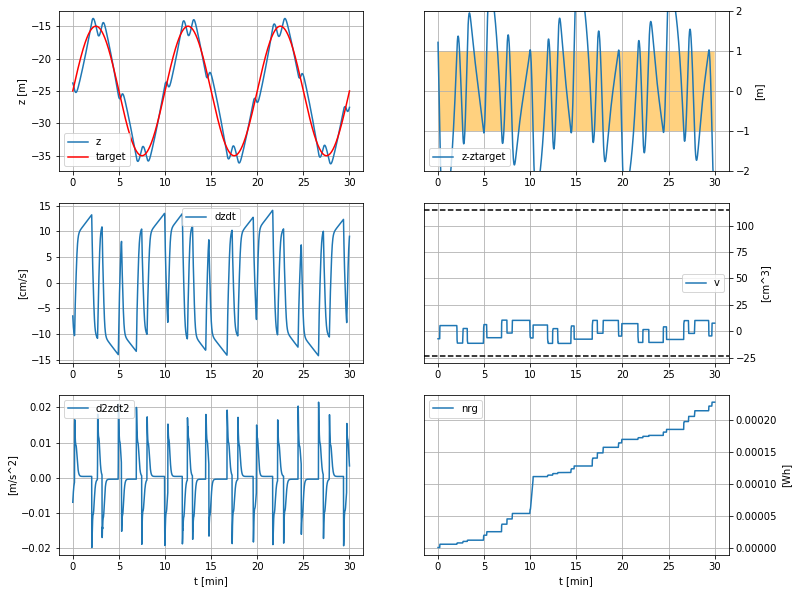

In [15]:
plot_log(f,z_target=z_target)

---

## Maintains depth level around moving isopycnals

In [16]:
eta = lambda t: 10.*np.sin(2.*np.pi/(60.*20.)*t)
z_target = lambda t: -25.+t*0.

In [17]:
f.time_step(w,T=1800., dt_step=.1, dt_store=1., usepiston=True, z_target=z_target, ctrl=control, eta=eta)

v None
 ctrl: tau = 2.0
 ctrl: dz_nochattering = 1.0
 ctrl: mode = feedback
 ctrl: Lv = 0.5
 ctrl: dt_ctrl = 0.1
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 1.0
Start time stepping for 30 min ...
(2, 4) (2, 2) (4, 4)
K [[0.  0. ]
 [0.5 0. ]
 [0.  0.5]
 [0.  0. ]]
ytilde [-4.08443540e-07 -1.77893843e-04]
x_hat [ 4.83266693e-01  2.74369942e+01 -8.11859343e-05  0.00000000e+00]
u 0
z -27.52766213352325
v 7.760987108658749e-06
gamma [[1.00201948e-02 9.10178550e-07 0.00000000e+00 0.00000000e+00]
 [9.10178550e-07 1.50000000e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00364071 0.        ]
 [0.6        0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-3.78529739e-03 -9.21412288e-05]
x_hat [ 9.38867101e-01  2.79179759e+01 -8.88928191e-05  0.00000000e+00]
u -5.9432550734067786e-06
z -27.433208937230738
v 6.176711505003044e-06
gam

 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00353719 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.07564726e+00  4.59408482e-05]
x_hat [ 1.15479837e+00  2.66475894e+01 -2.26008424e-04  0.00000000e+00]
u -6.310188195986469e-06
z -24.70915003175644
v 4.7537023804428835e-06
gamma [[4.01874276e-01 9.25776622e-07 0.00000000e+00 0.00000000e+00]
 [9.25776622e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00353615 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.07992648e+00  5.19328601e-05]
x_hat [ 1.15653831e+00  2.65095676e+01 -2.31324591e-04  0.00000000e+00]
u -6.310188195986469e-06
z -24.567663428177973
v 4.7537023804428835e-06
gamma [[4.02483897e-01 9.25516742e-07 0.00000000e+00 0.00000

(2, 4) (2, 2) (4, 4)
K [[0.00352517 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.8101475e+00  8.6151079e-05]
x_hat [ 1.17390856e+00  2.54326189e+01 -2.73186713e-04  0.00000000e+00]
u -1.0606594763638458e-06
z -23.57392895570743
v -9.527516596160598e-06
gamma [[4.09067281e-01 9.22888445e-07 0.00000000e+00 0.00000000e+00]
 [9.22888445e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00352512 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.80237645e+00  8.47578685e-05]
x_hat [ 1.17436421e+00  2.54862440e+01 -2.72752735e-04  0.00000000e+00]
u -1.1883300157112039e-06
z -23.630242257074762
v -9.527516596160598e-06
gamma [[4.09120044e-01 9.22847656e-07 0.00000000e+00 0.00000000e+00]
 [9.22847656e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.0035139  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.79605487e+00  7.86310105e-05]
x_hat [ 1.19649656e+00  2.71641760e+01 -2.67263441e-04  0.00000000e+00]
u -1.3085074612594476e-06
z -25.289038072066017
v -9.527516596160598e-06
gamma [[4.16501810e-01 9.19797998e-07 0.00000000e+00 0.00000000e+00]
 [9.19797998e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00351332 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.79727628e+00  7.80094496e-05]
x_hat [ 1.19759120e+00  2.72435803e+01 -2.67078808e-04  0.00000000e+00]
u -1.3085074612594476e-06
z -25.36689830253824
v -9.527516596160598e-06
gamma [[4.16890026e-01 9.19647193e-07 0.00000000e+00 0.00000000e+00]
 [9.19647193e-07 1.61803399e-04 0.00000000e+00 0.0000

(2, 4) (2, 2) (4, 4)
K [[0.00353544 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.88695914e+00  2.06154181e-07]
x_hat [ 1.14592462e+00  2.81259434e+01 -1.71688669e-04  0.00000000e+00]
u 5.519002850633365e-06
z -26.26126683267824
v 2.0161607064278667e-06
gamma [[4.02163068e-01 9.26282969e-07 0.00000000e+00 0.00000000e+00]
 [9.26282969e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00353809 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.88531366e+00 -6.26459616e-06]
x_hat [ 1.14150063e+00  2.81000097e+01 -1.66609320e-04  0.00000000e+00]
u 5.1992560006563955e-06
z -26.240629881498887
v 2.0161607064278667e-06
gamma [[4.00615652e-01 9.26941657e-07 0.00000000e+00 0.00000000e+00]
 [9.26941657e-07 1.61803399e-04 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.00357739 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.88727858e+00 -6.02023563e-05]
x_hat [ 1.07330936e+00  2.64752436e+01 -1.15766873e-04  0.00000000e+00]
u 2.450428076080119e-06
z -24.685112818039205
v 2.0161607064278667e-06
gamma [[3.79687225e-01 9.36962088e-07 0.00000000e+00 0.00000000e+00]
 [9.36962088e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00357888 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.88584875e+00 -6.00866723e-05]
x_hat [ 1.07057224e+00  2.63762851e+01 -1.14466534e-04  0.00000000e+00]
u 2.450428076080119e-06
z -24.58939640557516
v 2.0161607064278667e-06
gamma [[3.78961829e-01 9.37355788e-07 0.00000000e+00 0.00000000e+00]
 [9.37355788e-07 1.61803399e-04 0.00000000e+00 0.00000000

(2, 4) (2, 2) (4, 4)
K [[0.00357289 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.62461109e+00 -4.05709548e-05]
x_hat [ 1.08782783e+00  2.58738954e+01 -1.47835862e-04  0.00000000e+00]
u 1.395757674024242e-06
z -24.17214714897107
v -1.0302630034248567e-05
gamma [[3.82336484e-01 9.35278488e-07 0.00000000e+00 0.00000000e+00]
 [9.35278488e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00357245 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.62104213e+00 -4.06322918e-05]
x_hat [ 1.08870077e+00  2.59540730e+01 -1.47217827e-04  0.00000000e+00]
u 1.395757674024242e-06
z -24.252852877663642
v -1.0302630034248567e-05
gamma [[3.82554443e-01 9.35158793e-07 0.00000000e+00 0.00000000e+00]
 [9.35158793e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00356152 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.68702675e+00 -5.44250057e-05]
x_hat [ 1.10152371e+00  2.80197425e+01 -1.14315495e-04  0.00000000e+00]
u 6.677896840097246e-06
z -26.276954311439543
v 2.923137367813829e-06
gamma [[3.87699833e-01 9.32853943e-07 0.00000000e+00 0.00000000e+00]
 [9.32853943e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00356318 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.70210076e+00 -6.12994295e-05]
x_hat [ 1.09791492e+00  2.80632452e+01 -1.08528238e-04  0.00000000e+00]
u 6.960558188806859e-06
z -26.31763984800869
v 2.923137367813829e-06
gamma [[3.86845077e-01 9.33266572e-07 0.00000000e+00 0.00000000e+00]
 [9.33266572e-07 1.61803399e-04 0.00000000e+00 0.00000000e+

(2, 4) (2, 2) (4, 4)
K [[0.00358585 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.84188734e+00 -8.81307382e-05]
x_hat [ 1.06350545e+00  2.72393152e+01 -8.97307726e-05  0.00000000e+00]
u -3.3303614535162245e-07
z -25.479085483710204
v 2.923137367813829e-06
gamma [[3.76004298e-01 9.38744683e-07 0.00000000e+00 0.00000000e+00]
 [9.38744683e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00358569 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.84671116e+00 -8.68002052e-05]
x_hat [ 1.06364890e+00  2.71548687e+01 -9.17252085e-05  0.00000000e+00]
u -3.3303614535162245e-07
z -25.39260298515005
v 2.923137367813829e-06
gamma [[3.76068386e-01 9.38716354e-07 0.00000000e+00 0.00000000e+00]
 [9.38716354e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00357398 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.69607231e+00 -3.41612819e-05]
x_hat [ 1.08423417e+00  2.54169284e+01 -1.52584340e-04  0.00000000e+00]
u 1.97601964798827e-06
z -23.69071585882539
v -9.214044119352067e-06
gamma [[3.81659554e-01 9.35670349e-07 0.00000000e+00 0.00000000e+00]
 [9.35670349e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00357394 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.67991316e+00 -3.55981973e-05]
x_hat [ 1.08387468e+00  2.54569153e+01 -1.51022474e-04  0.00000000e+00]
u 2.243233263199588e-06
z -23.737016386467452
v -9.214044119352067e-06
gamma [[3.81651970e-01 9.35706783e-07 0.00000000e+00 0.00000000e+00]
 [9.35706783e-07 1.61803399e-04 0.00000000e+00 0.00000000e

(2, 4) (2, 2) (4, 4)
K [[0.0035701  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.58592401e+00 -6.83815021e-05]
x_hat [ 1.09296546e+00  2.75208734e+01 -1.17915491e-04  0.00000000e+00]
u 2.4844474572206055e-06
z -25.828672483465756
v -9.214044119352067e-06
gamma [[3.83734537e-01 9.34538927e-07 0.00000000e+00 0.00000000e+00]
 [9.34538927e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00356962 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.58625608e+00 -7.08582057e-05]
x_hat [ 1.09388609e+00  2.76278164e+01 -1.16787305e-04  0.00000000e+00]
u 2.4844474572206055e-06
z -25.934617166163513
v -9.214044119352067e-06
gamma [[3.83975854e-01 9.34412861e-07 0.00000000e+00 0.00000000e+00]
 [9.34412861e-07 1.61803399e-04 0.00000000e+00 0.00000

(2, 4) (2, 2) (4, 4)
K [[0.00358439 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.83880107e+00 -8.71631254e-05]
x_hat [ 1.06875896e+00  2.75896795e+01 -9.02916469e-05  0.00000000e+00]
u -1.98036472900427e-06
z -25.826771380429165
v 4.603855781258825e-06
gamma [[3.76876627e-01 9.38146803e-07 0.00000000e+00 0.00000000e+00]
 [9.38146803e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.0035834  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.84727592e+00 -8.38193504e-05]
x_hat [ 1.07026156e+00  2.75101397e+01 -9.38763563e-05  0.00000000e+00]
u -1.98036472900427e-06
z -25.742405272655873
v 4.603855781258825e-06
gamma [[3.77311827e-01 9.37915196e-07 0.00000000e+00 0.00000000e+00]
 [9.37915196e-07 1.61803399e-04 0.00000000e+00 0.00000000e

(2, 4) (2, 2) (4, 4)
K [[0.00356262 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.87859589e+00 -5.32989359e-06]
x_hat [ 1.10729561e+00  2.55482406e+01 -1.86898780e-04  0.00000000e+00]
u -6.198007155665985e-06
z -23.73395620315815
v -7.362750985722419e-06
gamma [[3.86447302e-01 9.32967068e-07 0.00000000e+00 0.00000000e+00]
 [9.32967068e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00356362 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.86516213e+00  6.27087509e-08]
x_hat [ 1.11123972e+00  2.54961559e+01 -1.92857618e-04  0.00000000e+00]
u -5.960038448993562e-06
z -23.683078204966645
v -7.362750985722419e-06
gamma [[3.87658482e-01 9.32238302e-07 0.00000000e+00 0.00000000e+00]
 [9.32238302e-07 1.61803399e-04 0.00000000e+00 0.000000

 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00355398 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.65820295e+00 -2.20977037e-06]
x_hat [ 1.11941294e+00  2.61509119e+01 -1.81278927e-04  0.00000000e+00]
u 2.798991082579655e-06
z -24.403381887967672
v -7.362750985722419e-06
gamma [[3.92016556e-01 9.30545521e-07 0.00000000e+00 0.00000000e+00]
 [9.30545521e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00355437 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.65237041e+00 -6.26692418e-06]
x_hat [ 1.11888817e+00  2.62432306e+01 -1.78599888e-04  0.00000000e+00]
u 2.798991082579655e-06
z -24.49854226272991
v -7.362750985722419e-06
gamma [[3.91813926e-01 9.30634317e-07 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.00356213 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.73164785e+00 -5.62078226e-05]
x_hat [ 1.10163611e+00  2.82043851e+01 -1.13426876e-04  0.00000000e+00]
u 3.650265610543429e-06
z -26.445330211893
v 6.816277776804631e-06
gamma [[3.87443197e-01 9.32928517e-07 0.00000000e+00 0.00000000e+00]
 [9.32928517e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00356347 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.74758752e+00 -5.93493714e-05]
x_hat [ 1.09998300e+00  2.82197253e+01 -1.11973530e-04  0.00000000e+00]
u 2.5893226248924617e-06
z -26.45679776185049
v 6.816277776804631e-06
gamma [[3.86793641e-01 9.33231670e-07 0.00000000e+00 0.00000000e+00]
 [9.33231670e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00

(2, 4) (2, 2) (4, 4)
K [[0.00355576 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.95745966e+00  1.98331682e-07]
x_hat [ 1.11791374e+00  2.65542541e+01 -1.75715444e-04  0.00000000e+00]
u -2.5006835393071347e-06
z -24.69589870402464
v 6.816277776804631e-06
gamma [[3.91154902e-01 9.30867355e-07 0.00000000e+00 0.00000000e+00]
 [9.30867355e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.0035556  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.95850833e+00  4.59603626e-06]
x_hat [ 1.11811928e+00  2.64547794e+01 -1.78128157e-04  0.00000000e+00]
u -2.5006835393071347e-06
z -24.595745942508767
v 6.816277776804631e-06
gamma [[3.91242924e-01 9.30827536e-07 0.00000000e+00 0.00000000e+00]
 [9.30827536e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00354461 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.69722334e+00  2.33373648e-05]
x_hat [ 1.13416885e+00  2.59649439e+01 -2.03809227e-04  0.00000000e+00]
u 3.822087236454528e-06
z -24.186617303972515
v -6.434035612168291e-06
gamma [[3.97082298e-01 9.28284683e-07 0.00000000e+00 0.00000000e+00]
 [9.28284683e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00354573 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.68589391e+00  1.79946548e-05]
x_hat [ 1.13243284e+00  2.60511953e+01 -1.99642713e-04  0.00000000e+00]
u 3.822087236454528e-06
z -24.2790506652912
v -6.434035612168291e-06
gamma [[3.96481816e-01 9.28550218e-07 0.00000000e+00 0.00000000e+00]
 [9.28550218e-07 1.61803399e-04 0.00000000e+00 0.00000000e

(2, 4) (2, 2) (4, 4)
K [[0.00356887 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.76933716e+00 -7.01215493e-05]
x_hat [ 1.09224675e+00  2.82954843e+01 -1.01717730e-04  0.00000000e+00]
u 1.2037777000319224e-06
z -26.533173672628482
v 6.9962099921967326e-06
gamma [[3.84168736e-01 9.34481990e-07 0.00000000e+00 0.00000000e+00]
 [9.34481990e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.0035694  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.78395472e+00 -7.11673567e-05]
x_hat [ 1.09212587e+00  2.82788187e+01 -1.02393315e-04  0.00000000e+00]
u 6.865946219968325e-07
z -26.511529835788235
v 6.9962099921967326e-06
gamma [[3.83955639e-01 9.34549823e-07 0.00000000e+00 0.00000000e+00]
 [9.34549823e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00357667 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.86914318e+00 -4.61527603e-05]
x_hat [ 1.07786793e+00  2.63783312e+01 -1.25647564e-04  0.00000000e+00]
u 2.4509936602697474e-07
z -24.592286767683802
v 6.9962099921967326e-06
gamma [[3.80253152e-01 9.36515176e-07 0.00000000e+00 0.00000000e+00]
 [9.36515176e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00357717 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.86786009e+00 -4.62736770e-05]
x_hat [ 1.07695561e+00  2.62951165e+01 -1.26288166e-04  0.00000000e+00]
u 2.4509936602697474e-07
z -24.510471375654348
v 6.9962099921967326e-06
gamma [[3.80007701e-01 9.36648547e-07 0.00000000e+00 0.00000000e+00]
 [9.36648547e-07 1.61803399e-04 0.00000000e+00 0.00000

(2, 4) (2, 2) (4, 4)
K [[0.00355184 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.71779059e+00  1.46201411e-05]
x_hat [ 1.12476265e+00  2.57944968e+01 -1.97225349e-04  0.00000000e+00]
u 1.4025344083107093e-06
z -24.01966936926817
v -4.494179721723074e-06
gamma [[3.93266840e-01 9.29839224e-07 0.00000000e+00 0.00000000e+00]
 [9.29839224e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00355167 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.70952530e+00  1.42182742e-05]
x_hat [ 1.12447435e+00  2.58566430e+01 -1.95550669e-04  0.00000000e+00]
u 1.4025344083107093e-06
z -24.08497170791218
v -4.494179721723074e-06
gamma [[3.93315155e-01 9.29853498e-07 0.00000000e+00 0.00000000e+00]
 [9.29853498e-07 1.61803399e-04 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.003558   0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.7279931e+00 -4.3215548e-05]
x_hat [ 1.11028650e+00  2.82391640e+01 -1.25179612e-04  0.00000000e+00]
u 2.230459837530333e-06
z -26.47367224819372
v 8.97308075979992e-06
gamma [[3.89698770e-01 9.31792953e-07 0.00000000e+00 0.00000000e+00]
 [9.31792953e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00355913 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.74825623e+00 -4.46330851e-05]
x_hat [ 1.10968542e+00  2.82627465e+01 -1.24665810e-04  0.00000000e+00]
u 1.3681017203698315e-06
z -26.490908139101542
v 8.97308075979992e-06
gamma [[3.89227317e-01 9.31960818e-07 0.00000000e+00 0.00000000e+00]
 [9.31960818e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]

(2, 4) (2, 2) (4, 4)
K [[0.00356774 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.89232711e+00 -3.36671126e-05]
x_hat [ 1.09354594e+00  2.67597470e+01 -1.37209862e-04  0.00000000e+00]
u 3.647977617449788e-07
z -24.94899340121941
v 8.97308075979992e-06
gamma [[3.84688962e-01 9.34211037e-07 0.00000000e+00 0.00000000e+00]
 [9.34211037e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00356837 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.89075755e+00 -3.32155544e-05]
x_hat [ 1.09238036e+00  2.66779936e+01 -1.37480827e-04  0.00000000e+00]
u 3.647977617449788e-07
z -24.868987548347544
v 8.97308075979992e-06
gamma [[3.84364613e-01 9.34378537e-07 0.00000000e+00 0.00000000e+00]
 [9.34378537e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00

(2, 4) (2, 2) (4, 4)
K [[0.00354107 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.80369509e+00  5.71475704e-05]
x_hat [ 1.15085938e+00  2.55933228e+01 -2.41875745e-04  0.00000000e+00]
u -4.9264074551240586e-06
z -23.763409729381184
v -2.5336754133764533e-06
gamma [[3.99800602e-01 9.26528155e-07 0.00000000e+00 0.00000000e+00]
 [9.26528155e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00353902 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.80382835e+00  5.98278121e-05]
x_hat [ 1.15413042e+00  2.56229711e+01 -2.45311847e-04  0.00000000e+00]
u -4.581236472105466e-06
z -23.78949441659176
v -2.5336754133764533e-06
gamma [[4.00956837e-01 9.26035901e-07 0.00000000e+00 0.00000000e+00]
 [9.26035901e-07 1.61803399e-04 0.00000000e+00 0.000

(2, 4) (2, 2) (4, 4)
K [[0.00351246 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.76184502e+00  8.69992384e-05]
x_hat [ 1.20087894e+00  2.73667792e+01 -2.69793944e-04  0.00000000e+00]
u -2.2562346953195693e-06
z -25.50115087418256
v -2.5336754133764533e-06
gamma [[4.17573849e-01 9.19292920e-07 0.00000000e+00 0.00000000e+00]
 [9.19292920e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00351139 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.76184177e+00  8.88178996e-05]
x_hat [ 1.20290212e+00  2.74725936e+01 -2.70350159e-04  0.00000000e+00]
u -2.2562346953195693e-06
z -25.60493685508577
v -2.5336754133764533e-06
gamma [[4.18303805e-01 9.19008096e-07 0.00000000e+00 0.00000000e+00]
 [9.19008096e-07 1.61803399e-04 0.00000000e+00 0.000

(2, 4) (2, 2) (4, 4)
K [[0.00352946 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.00173259e+00  4.62056950e-05]
x_hat [ 1.16204573e+00  2.74403072e+01 -2.13066232e-04  0.00000000e+00]
u 7.591320221993773e-08
z -25.51875219976415
v 1.0318382946778087e-05
gamma [[4.06123663e-01 9.24302907e-07 0.00000000e+00 0.00000000e+00]
 [9.24302907e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00353052 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.99982543e+00  4.34312348e-05]
x_hat [ 1.16009481e+00  2.73593324e+01 -2.12159023e-04  0.00000000e+00]
u 7.591320221993773e-08
z -25.440482237212752
v 1.0318382946778087e-05
gamma [[4.05464803e-01 9.24584158e-07 0.00000000e+00 0.00000000e+00]
 [9.24584158e-07 1.61803399e-04 0.00000000e+00 0.00000000

(2, 4) (2, 2) (4, 4)
K [[0.00353878 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.88040714e+00  6.21080582e-05]
x_hat [ 1.15376920e+00  2.55673011e+01 -2.47300846e-04  0.00000000e+00]
u -5.8957124282205715e-06
z -23.70516270715042
v -2.7759250032588136e-06
gamma [[4.00928634e-01 9.26104637e-07 0.00000000e+00 0.00000000e+00]
 [9.26104637e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.0035374  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.87114901e+00  6.53764736e-05]
x_hat [ 1.15708765e+00  2.55580176e+01 -2.51865280e-04  0.00000000e+00]
u -5.815773474336114e-06
z -23.696151401316946
v -2.7759250032588136e-06
gamma [[4.01955415e-01 9.25623930e-07 0.00000000e+00 0.00000000e+00]
 [9.25623930e-07 1.61803399e-04 0.00000000e+00 0.000

(2, 4) (2, 2) (4, 4)
K [[0.00351728 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.75288503e+00  8.35391461e-05]
x_hat [ 1.19011930e+00  2.69039035e+01 -2.63632917e-04  0.00000000e+00]
u -9.089341059979727e-07
z -25.051457405392835
v -2.7759250032588136e-06
gamma [[4.14252256e-01 9.20692102e-07 0.00000000e+00 0.00000000e+00]
 [9.20692102e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00351673 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.75008235e+00  8.17545144e-05]
x_hat [ 1.19124113e+00  2.70062578e+01 -2.62977028e-04  0.00000000e+00]
u -9.089341059979727e-07
z -25.153820901762316
v -2.7759250032588136e-06
gamma [[4.14615932e-01 9.20543346e-07 0.00000000e+00 0.00000000e+00]
 [9.20543346e-07 1.61803399e-04 0.00000000e+00 0.000

(2, 4) (2, 2) (4, 4)
K [[0.00352806 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.98630480e+00  3.91168143e-05]
x_hat [ 1.16554282e+00  2.79695177e+01 -2.06505584e-04  0.00000000e+00]
u -5.1233567795392444e-08
z -26.050744169424227
v 1.0415765593214883e-05
gamma [[4.07039273e-01 9.23856368e-07 0.00000000e+00 0.00000000e+00]
 [9.23856368e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00352882 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.98962138e+00  3.74016016e-05]
x_hat [ 1.16391875e+00  2.78983858e+01 -2.05814981e-04  0.00000000e+00]
u -2.5282556657303354e-08
z -25.979896315420223
v 1.0415765593214883e-05
gamma [[4.06550975e-01 9.24078027e-07 0.00000000e+00 0.00000000e+00]
 [9.24078027e-07 1.61803399e-04 0.00000000e+00 0.000

(2, 4) (2, 2) (4, 4)
K [[0.00355475 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.90673954e+00  2.41006142e-05]
x_hat [ 1.12704739e+00  2.56335171e+01 -2.10404714e-04  0.00000000e+00]
u -5.925469862936465e-06
z -23.788832509354535
v -2.248008621288016e-06
gamma [[3.92584181e-01 9.29963741e-07 0.00000000e+00 0.00000000e+00]
 [9.29963741e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00355215 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.88905106e+00  2.88325792e-05]
x_hat [ 1.13030362e+00  2.55863565e+01 -2.16415662e-04  0.00000000e+00]
u -6.562818302947607e-06
z -23.744468061117786
v -2.248008621288016e-06
gamma [[3.93591171e-01 9.29430818e-07 0.00000000e+00 0.00000000e+00]
 [9.29430818e-07 1.61803399e-04 0.00000000e+00 0.00000

(2, 4) (2, 2) (4, 4)
K [[0.00351726 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.79558338e+00  9.52869108e-05]
x_hat [ 1.18995874e+00  2.63216974e+01 -2.76546385e-04  0.00000000e+00]
u -1.5487860933166814e-06
z -24.453135541562016
v -2.248008621288016e-06
gamma [[4.14255087e-01 9.20701174e-07 0.00000000e+00 0.00000000e+00]
 [9.20701174e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00351677 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.79200979e+00  9.43191933e-05]
x_hat [ 1.19096157e+00  2.63978311e+01 -2.76289854e-04  0.00000000e+00]
u -1.5487860933166814e-06
z -24.529687775136438
v -2.248008621288016e-06
gamma [[4.14579095e-01 9.20568921e-07 0.00000000e+00 0.00000000e+00]
 [9.20568921e-07 1.61803399e-04 0.00000000e+00 0.000

(2, 4) (2, 2) (4, 4)
K [[0.00351876 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.93984731e+00  5.88895236e-05]
x_hat [ 1.18494104e+00  2.82458991e+01 -2.28498867e-04  0.00000000e+00]
u -1.6371213901853004e-06
z -26.326639381813003
v 1.0131602984193116e-05
gamma [[4.13166711e-01 9.21283205e-07 0.00000000e+00 0.00000000e+00]
 [9.21283205e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00351899 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.95744546e+00  5.98321183e-05]
x_hat [ 1.18482321e+00  2.82141840e+01 -2.29160942e-04  0.00000000e+00]
u -1.8072921611284247e-06
z -26.288453871399238
v 1.0131602984193116e-05
gamma [[4.13035728e-01 9.21302409e-07 0.00000000e+00 0.00000000e+00]
 [9.21302409e-07 1.61803399e-04 0.00000000e+00 0.000

(2, 4) (2, 2) (4, 4)
K [[0.00353246 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.02401027e+00  6.74828193e-05]
x_hat [ 1.15754995e+00  2.61070148e+01 -2.37114919e-04  0.00000000e+00]
u -1.534646639170638e-06
z -24.182117584988685
v 1.0131602984193116e-05
gamma [[4.04344693e-01 9.25009437e-07 0.00000000e+00 0.00000000e+00]
 [9.25009437e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00353322 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.02259512e+00  6.79615155e-05]
x_hat [ 1.15613375e+00  2.60073860e+01 -2.37348748e-04  0.00000000e+00]
u -1.534646639170638e-06
z -24.084418295206095
v 1.0131602984193116e-05
gamma [[4.03884612e-01 9.25207065e-07 0.00000000e+00 0.00000000e+00]
 [9.25207065e-07 1.61803399e-04 0.00000000e+00 0.00000

(2, 4) (2, 2) (4, 4)
K [[0.00350804 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.85054700e+00  1.24321662e-04]
x_hat [ 1.20425615e+00  2.58610375e+01 -3.04899665e-04  0.00000000e+00]
u 2.477275355693282e-07
z -23.955671818459297
v -3.1912324898994775e-06
gamma [[4.20280741e-01 9.18496133e-07 0.00000000e+00 0.00000000e+00]
 [9.18496133e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00350834 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.84260923e+00  1.21540039e-04]
x_hat [ 1.20328577e+00  2.59200340e+01 -3.01987025e-04  0.00000000e+00]
u 5.863019746598164e-07
z -24.0184296275111
v -3.1912324898994775e-06
gamma [[4.20050762e-01 9.18607750e-07 0.00000000e+00 0.00000000e+00]
 [9.18607750e-07 1.61803399e-04 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.00351297 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.78321442e+00  5.10129477e-05]
x_hat [ 1.17700793e+00  2.80584789e+01 -2.14782307e-04  0.00000000e+00]
u 5.411894888105589e-06
z -26.205841076652113
v 8.903758125042066e-06
gamma [[4.12624590e-01 9.22881368e-07 0.00000000e+00 0.00000000e+00]
 [9.22881368e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00352509 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.78861537e+00  4.54718413e-05]
x_hat [ 1.17300229e+00  2.81237567e+01 -2.08796347e-04  0.00000000e+00]
u 5.115605726108213e-06
z -26.269864190570576
v 8.903758125042066e-06
gamma [[4.11008167e-01 9.22315373e-07 0.00000000e+00 0.00000000e+00]
 [9.22315373e-07 1.61803399e-04 0.00000000e+00 0.00000000e

(2, 4) (2, 2) (4, 4)
K [[0.00353164 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.03261769e+00  5.57113584e-05]
x_hat [ 1.16079087e+00  2.67736064e+01 -2.28114695e-04  0.00000000e+00]
u -2.636367514616882e-06
z -24.843136230610213
v 8.903758125042066e-06
gamma [[4.04954072e-01 9.24656762e-07 0.00000000e+00 0.00000000e+00]
 [9.24656762e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00353187 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-2.03343651e+00  5.72065991e-05]
x_hat [ 1.16028860e+00  2.66704825e+01 -2.29656099e-04  0.00000000e+00]
u -2.636367514616882e-06
z -24.740171021947788
v 8.903758125042066e-06
gamma [[4.04805947e-01 9.24723967e-07 0.00000000e+00 0.00000000e+00]
 [9.24723967e-07 1.61803399e-04 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.00352166 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.82359868e+00  9.22035224e-05]
x_hat [ 1.17845880e+00  2.56182156e+01 -2.73631902e-04  0.00000000e+00]
u 9.727242956719777e-07
z -23.748639683235076
v -5.021423633962509e-06
gamma [[4.11142238e-01 9.22093679e-07 0.00000000e+00 0.00000000e+00]
 [9.22093679e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00352208 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.81178989e+00  8.92370815e-05]
x_hat [ 1.17729404e+00  2.56705454e+01 -2.70591840e-04  0.00000000e+00]
u 1.332019497815427e-06
z -23.80642590748483
v -5.021423633962509e-06
gamma [[4.10853345e-01 9.22238718e-07 0.00000000e+00 0.00000000e+00]
 [9.22238718e-07 1.61803399e-04 0.00000000e+00 0.00000000

(2, 4) (2, 2) (4, 4)
K [[0.00353288 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.72536517e+00 -7.41782734e-07]
x_hat [ 1.14109359e+00  2.79955955e+01 -1.66864827e-04  0.00000000e+00]
u 6.2013126686307135e-06
z -26.20060360372335
v 6.92626967026308e-06
gamma [[4.00430075e-01 9.27900821e-07 0.00000000e+00 0.00000000e+00]
 [9.27900821e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00354427 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.73052713e+00 -5.63116503e-06]
x_hat [ 1.13724762e+00  2.80610311e+01 -1.60581255e-04  0.00000000e+00]
u 6.391356001081922e-06
z -26.26506772018686
v 6.92626967026308e-06
gamma [[3.99016128e-01 9.27432271e-07 0.00000000e+00 0.00000000e+00]
 [9.27432271e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00

(2, 4) (2, 2) (4, 4)
K [[0.00355115 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.96973076e+00  1.47301431e-06]
x_hat [ 1.12666952e+00  2.71231633e+01 -1.75130862e-04  0.00000000e+00]
u -2.714640096068058e-06
z -25.251552460343824
v 6.92626967026308e-06
gamma [[3.93707958e-01 9.29626111e-07 0.00000000e+00 0.00000000e+00]
 [9.29626111e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00355086 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.97364515e+00  2.69779448e-06]
x_hat [ 1.12705732e+00  2.70230449e+01 -1.77793865e-04  0.00000000e+00]
u -2.714640096068058e-06
z -25.149517263849415
v 6.92626967026308e-06
gamma [[3.93851917e-01 9.29567396e-07 0.00000000e+00 0.00000000e+00]
 [9.29567396e-07 1.61803399e-04 0.00000000e+00 0.00000000e

(2, 4) (2, 2) (4, 4)
K [[0.00353611 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.83273095e+00  5.89972861e-05]
x_hat [ 1.15278086e+00  2.54191333e+01 -2.43087024e-04  0.00000000e+00]
u 8.251400894890004e-07
z -23.57218035800938
v -7.308581991953872e-06
gamma [[4.02244344e-01 9.25762139e-07 0.00000000e+00 0.00000000e+00]
 [9.25762139e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.0035361  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.81519189e+00  5.65217617e-05]
x_hat [ 1.15168694e+00  2.54436452e+01 -2.40483502e-04  0.00000000e+00]
u 1.5216664643976145e-06
z -23.603941409824255
v -7.308581991953872e-06
gamma [[4.02154636e-01 9.25868443e-07 0.00000000e+00 0.00000000e+00]
 [9.25868443e-07 1.61803399e-04 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.0035467  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.66308716e+00 -1.15014606e-05]
x_hat [ 1.13372356e+00  2.74495483e+01 -1.72420467e-04  0.00000000e+00]
u 2.49740227737165e-06
z -25.686387615900905
v -7.308581991953872e-06
gamma [[3.96127273e-01 9.28557915e-07 0.00000000e+00 0.00000000e+00]
 [9.28557915e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00354678 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.66256538e+00 -1.46457034e-05]
x_hat [ 1.13368104e+00  2.75498532e+01 -1.70203391e-04  0.00000000e+00]
u 2.49740227737165e-06
z -25.78698246609131
v -7.308581991953872e-06
gamma [[3.96093023e-01 9.28569552e-07 0.00000000e+00 0.00000000e+00]
 [9.28569552e-07 1.61803399e-04 0.00000000e+00 0.00000000e+

(2, 4) (2, 2) (4, 4)
K [[0.00356292 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.88174551e+00 -4.17323889e-05]
x_hat [ 1.10733163e+00  2.78558914e+01 -1.34643252e-04  0.00000000e+00]
u -3.2223929368314307e-06
z -26.038203679749998
v 5.934323214623856e-06
gamma [[3.87521802e-01 9.32566000e-07 0.00000000e+00 0.00000000e+00]
 [9.32566000e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00356209 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.89406233e+00 -3.91373287e-05]
x_hat [ 1.10926930e+00  2.77858813e+01 -1.38883676e-04  0.00000000e+00]
u -3.4913162829836635e-06
z -25.961828181551958
v 5.934323214623856e-06
gamma [[3.87980387e-01 9.32314918e-07 0.00000000e+00 0.00000000e+00]
 [9.32314918e-07 1.61803399e-04 0.00000000e+00 0.00000

(2, 4) (2, 2) (4, 4)
K [[0.00354743 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.95019015e+00  3.64909317e-05]
x_hat [ 1.13790939e+00  2.54962680e+01 -2.28373166e-04  0.00000000e+00]
u -6.617189856063269e-06
z -23.62378567100341
v -7.488500160333723e-06
gamma [[3.95921774e-01 9.28399590e-07 0.00000000e+00 0.00000000e+00]
 [9.28399590e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00354617 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.93117436e+00  4.16044159e-05]
x_hat [ 1.14128178e+00  2.54337977e+01 -2.33643965e-04  0.00000000e+00]
u -6.067128308310824e-06
z -23.565093156856936
v -7.488500160333723e-06
gamma [[3.96928743e-01 9.27877775e-07 0.00000000e+00 0.00000000e+00]
 [9.27877775e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00353322 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.73316371e+00  4.14868554e-05]
x_hat [ 1.16024693e+00  2.66174800e+01 -2.28242514e-04  0.00000000e+00]
u -1.9400542610617074e-07
z -24.802213089765814
v -7.488500160333723e-06
gamma [[4.04141309e-01 9.24891275e-07 0.00000000e+00 0.00000000e+00]
 [9.24891275e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00353277 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.73404748e+00  4.13766048e-05]
x_hat [ 1.16111466e+00  2.66999007e+01 -2.27644550e-04  0.00000000e+00]
u -1.9400542610617074e-07
z -24.883432632231994
v -7.488500160333723e-06
gamma [[4.04422682e-01 9.24767053e-07 0.00000000e+00 0.00000000e+00]
 [9.24767053e-07 1.61803399e-04 0.00000000e+00 0.000

(2, 4) (2, 2) (4, 4)
K [[0.00354862 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.84662214e+00 -2.67758397e-05]
x_hat [ 1.12428807e+00  2.80915731e+01 -1.45218869e-04  0.00000000e+00]
u 3.8185941722767195e-06
z -26.26526918325761
v 4.055653454562122e-06
gamma [[3.94669421e-01 9.29544936e-07 0.00000000e+00 0.00000000e+00]
 [9.29544936e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00355055 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.85012228e+00 -2.93981391e-05]
x_hat [ 1.12142284e+00  2.80658538e+01 -1.42548201e-04  0.00000000e+00]
u 3.233363339275442e-06
z -26.241449839017314
v 4.055653454562122e-06
gamma [[3.93638203e-01 9.29997606e-07 0.00000000e+00 0.00000000e+00]
 [9.29997606e-07 1.61803399e-04 0.00000000e+00 0.00000000e

(2, 4) (2, 2) (4, 4)
K [[0.00356322 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.96418008e+00 -1.32165965e-05]
x_hat [ 1.10166455e+00  2.61207999e+01 -1.62405756e-04  0.00000000e+00]
u -7.343341302887467e-07
z -24.27467517226762
v 4.055653454562122e-06
gamma [[3.87017346e-01 9.33029910e-07 0.00000000e+00 0.00000000e+00]
 [9.33029910e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00356386 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.96493878e+00 -1.13490151e-05]
x_hat [ 1.10039879e+00  2.60010628e+01 -1.63357316e-04  0.00000000e+00]
u -7.343341302887467e-07
z -24.15586074277158
v 4.055653454562122e-06
gamma [[3.86676047e-01 9.33205871e-07 0.00000000e+00 0.00000000e+00]
 [9.33205871e-07 1.61803399e-04 0.00000000e+00 0.00000000e

(2, 4) (2, 2) (4, 4)
K [[0.00355207 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.68626724e+00  7.21356753e-06]
x_hat [ 1.12660149e+00  2.60329796e+01 -1.96026721e-04  0.00000000e+00]
u -2.786026005632274e-07
z -24.26964215440526
v -9.317157969751977e-06
gamma [[3.93302963e-01 9.29750222e-07 0.00000000e+00 0.00000000e+00]
 [9.29750222e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00355133 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.68663676e+00  8.52246685e-06]
x_hat [ 1.12796868e+00  2.61111925e+01 -1.96142200e-04  0.00000000e+00]
u -2.786026005632274e-07
z -24.34634451278213
v -9.317157969751977e-06
gamma [[3.93714788e-01 9.29553104e-07 0.00000000e+00 0.00000000e+00]
 [9.29553104e-07 1.61803399e-04 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.00354719 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.79019185e+00 -2.48187883e-05]
x_hat [ 1.12594918e+00  2.81041635e+01 -1.45692145e-04  0.00000000e+00]
u 5.28492630032182e-06
z -26.297561815003842
v 3.6506693237958614e-06
gamma [[3.95278216e-01 9.29337465e-07 0.00000000e+00 0.00000000e+00]
 [9.29337465e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00354975 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.79812471e+00 -2.95670103e-05]
x_hat [ 1.12246885e+00  2.81124276e+01 -1.41100867e-04  0.00000000e+00]
u 5.157204581650477e-06
z -26.306039216509433
v 3.6506693237958614e-06
gamma [[3.94174659e-01 9.29753030e-07 0.00000000e+00 0.00000000e+00]
 [9.29753030e-07 1.61803399e-04 0.00000000e+00 0.00000000

(2, 4) (2, 2) (4, 4)
K [[0.00356706 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.94666660e+00 -3.18339201e-05]
x_hat [ 1.09515953e+00  2.65269690e+01 -1.45219382e-04  0.00000000e+00]
u -6.241430127721127e-07
z -24.69424042179769
v 3.6506693237958614e-06
gamma [[3.85057478e-01 9.34001220e-07 0.00000000e+00 0.00000000e+00]
 [9.34001220e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00356757 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.94924446e+00 -3.04183104e-05]
x_hat [ 1.09414050e+00  2.64104752e+01 -1.46425746e-04  0.00000000e+00]
u -6.241430127721127e-07
z -24.577725553925024
v 3.6506693237958614e-06
gamma [[3.84794484e-01 9.34140085e-07 0.00000000e+00 0.00000000e+00]
 [9.34140085e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00355096 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.69632101e+00  1.48464218e-05]
x_hat [ 1.12887428e+00  2.58800524e+01 -2.02680136e-04  0.00000000e+00]
u -6.849515721998252e-07
z -24.110761871230995
v -1.003201235909118e-05
gamma [[3.93935881e-01 9.29439091e-07 0.00000000e+00 0.00000000e+00]
 [9.29439091e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00355014 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.69628775e+00  1.36785397e-05]
x_hat [ 1.13041680e+00  2.59545411e+01 -2.03103273e-04  0.00000000e+00]
u -6.849515721998252e-07
z -24.18376600108153
v -1.003201235909118e-05
gamma [[3.94388682e-01 9.29224277e-07 0.00000000e+00 0.00000000e+00]
 [9.29224277e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00353194 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.79358885e+00  1.10128153e-05]
x_hat [ 1.15407082e+00  2.80704195e+01 -1.82289784e-04  0.00000000e+00]
u 7.0574394723958435e-06
z -26.23331637661559
v 1.5368895957200967e-06
gamma [[4.04500322e-01 9.25141795e-07 0.00000000e+00 0.00000000e+00]
 [9.25141795e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00353373 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.80566242e+00  6.09174666e-06]
x_hat [ 1.14918084e+00  2.81021489e+01 -1.76703756e-04  0.00000000e+00]
u 5.469429294381041e-06
z -26.264757051067733
v 2.96824796564466e-06
gamma [[4.03157738e-01 9.25779182e-07 0.00000000e+00 0.00000000e+00]
 [9.25779182e-07 1.61803399e-04 0.00000000e+00 0.00000000e

(2, 4) (2, 2) (4, 4)
K [[0.00356515 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.92703519e+00 -3.71400515e-05]
x_hat [ 1.09778183e+00  2.69221812e+01 -1.39099701e-04  0.00000000e+00]
u 4.1641886758236484e-07
z -25.093779516308757
v 2.96824796564466e-06
gamma [[3.85990588e-01 9.33564182e-07 0.00000000e+00 0.00000000e+00]
 [9.33564182e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.0035659  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.92985132e+00 -3.74121851e-05]
x_hat [ 1.09630474e+00  2.68203677e+01 -1.39399370e-04  0.00000000e+00]
u 4.1641886758236484e-07
z -24.99233017246002
v 2.96824796564466e-06
gamma [[3.85591588e-01 9.33772521e-07 0.00000000e+00 0.00000000e+00]
 [9.33772521e-07 1.61803399e-04 0.00000000e+00 0.00000000e+

 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00355859 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.68593177e+00 -3.47295240e-06]
x_hat [ 1.11394173e+00  2.56569464e+01 -1.87293099e-04  0.00000000e+00]
u 5.5378472250220964e-08
z -23.906060325100633
v -1.0343456325191581e-05
gamma [[3.89715891e-01 9.31532731e-07 0.00000000e+00 0.00000000e+00]
 [9.31532731e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00355814 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.68118312e+00 -2.13225596e-06]
x_hat [ 1.11507960e+00  2.57258779e+01 -1.87328764e-04  0.00000000e+00]
u 5.147309014852951e-09
z -23.975763410252398
v -1.0343456325191581e-05
gamma [[3.89988780e-01 9.31379264e-07 0.00000000e+00 0.000

(2, 4) (2, 2) (4, 4)
K [[0.00353865 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.71357641e+00 -5.07869725e-06]
x_hat [ 1.13871500e+00  2.79143948e+01 -1.67106224e-04  0.00000000e+00]
u 6.104575951463484e-06
z -26.11615774086122
v 9.006572222266073e-07
gamma [[4.00938408e-01 9.26244880e-07 0.00000000e+00 0.00000000e+00]
 [9.26244880e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00353794 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.73385353e+00 -9.73079253e-06]
x_hat [ 1.13626003e+00  2.79753952e+01 -1.60912409e-04  0.00000000e+00]
u 6.380066511983003e-06
z -26.18053891139676
v 2.349284821678579e-06
gamma [[3.98655085e-01 9.28196110e-07 0.00000000e+00 0.00000000e+00]
 [9.28196110e-07 1.61803399e-04 0.00000000e+00 0.00000000e+0

(2, 4) (2, 2) (4, 4)
K [[0.00358127 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.84331911e+00 -8.13581282e-05]
x_hat [ 1.06948567e+00  2.73013408e+01 -9.44004149e-05  0.00000000e+00]
u 1.181563737369004e-06
z -25.533373061074556
v 2.349284821678579e-06
gamma [[3.78022399e-01 9.37724560e-07 0.00000000e+00 0.00000000e+00]
 [9.37724560e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00358179 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.84697457e+00 -8.11683656e-05]
x_hat [ 1.06842790e+00  2.72227179e+01 -9.47724547e-05  0.00000000e+00]
u 1.181563737369004e-06
z -25.454365302370757
v 2.349284821678579e-06
gamma [[3.77764514e-01 9.37872238e-07 0.00000000e+00 0.00000000e+00]
 [9.37872238e-07 1.61803399e-04 0.00000000e+00 0.00000000e

(2, 4) (2, 2) (4, 4)
K [[0.00358344 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.66116434e+00 -5.59074261e-05]
x_hat [ 1.06755200e+00  2.54079641e+01 -1.31966700e-04  0.00000000e+00]
u 1.8369717229452298e-06
z -23.71194507572611
v -1.0061257298185933e-05
gamma [[3.77102472e-01 9.38139964e-07 0.00000000e+00 0.00000000e+00]
 [9.38139964e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00358338 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.64592424e+00 -5.53986676e-05]
x_hat [ 1.06769426e+00  2.54523811e+01 -1.31188093e-04  0.00000000e+00]
u 1.8389652828083176e-06
z -23.762038654337577
v -1.0061257298185933e-05
gamma [[3.77141281e-01 9.38127883e-07 0.00000000e+00 0.00000000e+00]
 [9.38127883e-07 1.61803399e-04 0.00000000e+00 0.0000

(2, 4) (2, 2) (4, 4)
K [[0.00356757 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.60286183e+00 -5.87336847e-05]
x_hat [ 1.09847112e+00  2.77449680e+01 -1.06936812e-04  0.00000000e+00]
u 1.563094654537135e-05
z -26.04130058196605
v -2.1637301365559037e-06
gamma [[3.85086515e-01 9.33793436e-07 0.00000000e+00 0.00000000e+00]
 [9.33793436e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00356677 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.61380435e+00 -7.06541276e-05]
x_hat [ 1.08799353e+00  2.78402971e+01 -1.01964735e-04  0.00000000e+00]
u 6.324432730992172e-06
z -26.13116459343877
v 1.8503663455367558e-06
gamma [[3.85470654e-01 9.33605424e-07 0.00000000e+00 0.00000000e+00]
 [9.33605424e-07 1.61803399e-04 0.00000000e+00 0.00000000

(2, 4) (2, 2) (4, 4)
K [[0.00359081 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.81223413e+00 -1.04190955e-04]
x_hat [ 1.05629466e+00  2.75188506e+01 -7.53572794e-05  0.00000000e+00]
u -9.133859066173781e-07
z -25.7779653890687
v 3.30376710660509e-06
gamma [[3.73820595e-01 9.39910984e-07 0.00000000e+00 0.00000000e+00]
 [9.39910984e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00359014 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.82000330e+00 -1.00079182e-04]
x_hat [ 1.05727879e+00  2.74437873e+01 -7.81862314e-05  0.00000000e+00]
u -9.133859066173781e-07
z -25.698849160504558
v 3.30376710660509e-06
gamma [[3.74114572e-01 9.39749763e-07 0.00000000e+00 0.00000000e+00]
 [9.39749763e-07 1.61803399e-04 0.00000000e+00 0.00000000e+0

(2, 4) (2, 2) (4, 4)
K [[0.00356828 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.76240169e+00 -1.47039589e-05]
x_hat [ 1.09739605e+00  2.53756003e+01 -1.72206366e-04  0.00000000e+00]
u -1.7733761977737223e-07
z -23.612551034024637
v -8.807757011400377e-06
gamma [[3.84719285e-01 9.33927417e-07 0.00000000e+00 0.00000000e+00]
 [9.33927417e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00356729 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.74591996e+00 -1.60708357e-05]
x_hat [ 1.09791914e+00  2.53877303e+01 -1.71726221e-04  0.00000000e+00]
u 7.87749062643922e-07
z -23.629683600972392
v -8.807757011400377e-06
gamma [[3.85148039e-01 9.33765342e-07 0.00000000e+00 0.00000000e+00]
 [9.33765342e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00356615 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.59415786e+00 -6.06198197e-05]
x_hat [ 1.09970208e+00  2.75826491e+01 -1.25052242e-04  0.00000000e+00]
u 2.6496042269158267e-06
z -25.880368838359395
v -8.807757011400377e-06
gamma [[3.85720072e-01 9.33537961e-07 0.00000000e+00 0.00000000e+00]
 [9.33537961e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.0035658  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.59407266e+00 -6.28125869e-05]
x_hat [ 1.10039958e+00  2.76914759e+01 -1.23604903e-04  0.00000000e+00]
u 2.6496042269158267e-06
z -25.988577661290474
v -8.807757011400377e-06
gamma [[3.85902338e-01 9.33443330e-07 0.00000000e+00 0.00000000e+00]
 [9.33443330e-07 1.61803399e-04 0.00000000e+00 0.00000

(2, 4) (2, 2) (4, 4)
K [[0.00357212 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.89593205e+00 -5.28990965e-05]
x_hat [ 1.08962762e+00  2.72656016e+01 -1.23703596e-04  0.00000000e+00]
u -2.177585107324908e-06
z -25.459551189851936
v 5.11304515609611e-06
gamma [[3.82741951e-01 9.35034290e-07 0.00000000e+00 0.00000000e+00]
 [9.35034290e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00357151 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.90070564e+00 -5.06940877e-05]
x_hat [ 1.09055000e+00  2.71737402e+01 -1.26851491e-04  0.00000000e+00]
u -2.177585107324908e-06
z -25.364896523838418
v 5.11304515609611e-06
gamma [[3.83027092e-01 9.34894293e-07 0.00000000e+00 0.00000000e+00]
 [9.34894293e-07 1.61803399e-04 0.00000000e+00 0.00000000e

(2, 4) (2, 2) (4, 4)
K [[0.00354498 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.78508087e+00  3.78363911e-05]
x_hat [ 1.13791844e+00  2.54777345e+01 -2.22466648e-04  0.00000000e+00]
u 2.3775738339073274e-07
z -23.664564464208127
v -6.8136816322116294e-06
gamma [[3.97144957e-01 9.27987790e-07 0.00000000e+00 0.00000000e+00]
 [9.27987790e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.0035446  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.77277705e+00  3.58303455e-05]
x_hat [ 1.13775300e+00  2.55137327e+01 -2.20895006e-04  0.00000000e+00]
u 8.858314834381751e-07
z -23.704955632184255
v -6.8136816322116294e-06
gamma [[3.97308817e-01 9.27963662e-07 0.00000000e+00 0.00000000e+00]
 [9.27963662e-07 1.61803399e-04 0.00000000e+00 0.0000

(2, 4) (2, 2) (4, 4)
K [[0.00355073 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.63757823e+00 -3.57694719e-05]
x_hat [ 1.11183768e+00  2.78950483e+01 -1.32603959e-04  0.00000000e+00]
u 5.9497352900575075e-06
z -26.14871200171629
v 5.981214385886853e-06
gamma [[3.93891940e-01 9.29577401e-07 0.00000000e+00 0.00000000e+00]
 [9.29577401e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00355067 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.65827568e+00 -3.97169903e-05]
x_hat [ 1.11049645e+00  2.79761273e+01 -1.26558428e-04  0.00000000e+00]
u 6.805734387270224e-06
z -26.236772502478715
v 5.981214385886853e-06
gamma [[3.90785516e-01 9.32150802e-07 0.00000000e+00 0.00000000e+00]
 [9.32150802e-07 1.61803399e-04 0.00000000e+00 0.00000000e

(2, 4) (2, 2) (4, 4)
K [[0.00357127 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.88654106e+00 -5.31310153e-05]
x_hat [ 1.08902860e+00  2.72433612e+01 -1.21927512e-04  0.00000000e+00]
u -5.785186000109774e-07
z -25.4403148444183
v 5.981214385886853e-06
gamma [[3.83027064e-01 9.34983898e-07 0.00000000e+00 0.00000000e+00]
 [9.34983898e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00357132 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.88780256e+00 -5.13636494e-05]
x_hat [ 1.08882770e+00  2.71589217e+01 -1.23489157e-04  0.00000000e+00]
u -5.785186000109774e-07
z -25.355557637940375
v 5.981214385886853e-06
gamma [[3.82988568e-01 9.35009070e-07 0.00000000e+00 0.00000000e+00]
 [9.35009070e-07 1.61803399e-04 0.00000000e+00 0.00000000e

(2, 4) (2, 2) (4, 4)
K [[0.00355614 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.78453755e+00  1.75630992e-05]
x_hat [ 1.12200505e+00  2.54780289e+01 -2.04269660e-04  0.00000000e+00]
u -2.8328435162687366e-06
z -23.68343537088877
v -5.834521588776929e-06
gamma [[3.91275256e-01 9.30555707e-07 0.00000000e+00 0.00000000e+00]
 [9.30555707e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00355441 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.77637365e+00  1.96567487e-05]
x_hat [ 1.12411941e+00  2.54958607e+01 -2.05767650e-04  0.00000000e+00]
u -1.8742294700843386e-06
z -23.701653694857068
v -5.834521588776929e-06
gamma [[3.92134886e-01 9.30182013e-07 0.00000000e+00 0.00000000e+00]
 [9.30182013e-07 1.61803399e-04 0.00000000e+00 0.0000

(2, 4) (2, 2) (4, 4)
K [[0.00355729 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.59512877e+00 -2.93453936e-05]
x_hat [ 1.11474426e+00  2.78164040e+01 -1.34156868e-04  0.00000000e+00]
u 8.019551961700437e-06
z -26.098043399699485
v 7.63432806515935e-06
gamma [[3.90322634e-01 9.31284749e-07 0.00000000e+00 0.00000000e+00]
 [9.31284749e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00355719 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.61148719e+00 -3.78126965e-05]
x_hat [ 1.11062477e+00  2.79294621e+01 -1.28490710e-04  0.00000000e+00]
u 6.389911814689312e-06
z -26.204917593710032
v 7.63432806515935e-06
gamma [[3.90335194e-01 9.31291333e-07 0.00000000e+00 0.00000000e+00]
 [9.31291333e-07 1.61803399e-04 0.00000000e+00 0.00000000e+0

(2, 4) (2, 2) (4, 4)
K [[0.00357095 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.88144316e+00 -5.13220376e-05]
x_hat [ 1.08843069e+00  2.72173268e+01 -1.20955709e-04  0.00000000e+00]
u 2.510510181312137e-07
z -25.41618285239993
v 7.63432806515935e-06
gamma [[3.83107007e-01 9.34996429e-07 0.00000000e+00 0.00000000e+00]
 [9.34996429e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00357137 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.88097743e+00 -5.10654975e-05]
x_hat [ 1.08763489e+00  2.71365319e+01 -1.21682077e-04  0.00000000e+00]
u 2.510510181312137e-07
z -25.33635094963317
v 7.63432806515935e-06
gamma [[3.82892125e-01 9.35110859e-07 0.00000000e+00 0.00000000e+00]
 [9.35110859e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]

(2, 4) (2, 2) (4, 4)
K [[0.00356554 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.78321380e+00  1.56263684e-06]
x_hat [ 1.10816718e+00  2.54782904e+01 -1.89103362e-04  0.00000000e+00]
u -5.8217891876723076e-06
z -23.69996474949002
v -3.862317734551524e-06
gamma [[3.86532446e-01 9.32785715e-07 0.00000000e+00 0.00000000e+00]
 [9.32785715e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00356292 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.77863825e+00  6.29153260e-06]
x_hat [ 1.11261748e+00  2.54808615e+01 -1.94449473e-04  0.00000000e+00]
u -5.466534099488101e-06
z -23.69965164599861
v -3.862317734551524e-06
gamma [[3.87861591e-01 9.32124051e-07 0.00000000e+00 0.00000000e+00]
 [9.32124051e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00353784 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.66450572e+00  1.61266210e-05]
x_hat [ 1.15265240e+00  2.74599789e+01 -1.99320866e-04  0.00000000e+00]
u 3.6272145460230463e-07
z -25.67880387840159
v -3.862317734551524e-06
gamma [[4.01433903e-01 9.26030119e-07 0.00000000e+00 0.00000000e+00]
 [9.26030119e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00353712 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.66388396e+00  1.63881284e-05]
x_hat [ 1.15404456e+00  2.75784091e+01 -1.98644468e-04  0.00000000e+00]
u 3.6272145460230463e-07
z -25.79609539272409
v -3.862317734551524e-06
gamma [[4.01869130e-01 9.25832990e-07 0.00000000e+00 0.00000000e+00]
 [9.25832990e-07 1.61803399e-04 0.00000000e+00 0.0000000

(2, 4) (2, 2) (4, 4)
K [[0.00355498 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.92566538e+00 -1.56157580e-05]
x_hat [ 1.11639673e+00  2.73750069e+01 -1.53502056e-04  0.00000000e+00]
u 3.2175886751682404e-07
z -25.52858960848918
v 9.474188290825942e-06
gamma [[3.91388173e-01 9.30894120e-07 0.00000000e+00 0.00000000e+00]
 [9.30894120e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.0035557  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.92455931e+00 -1.55217195e-05]
x_hat [ 1.11505806e+00  2.72951174e+01 -1.53477390e-04  0.00000000e+00]
u 3.2175886751682404e-07
z -25.450447823333818
v 9.474188290825942e-06
gamma [[3.90995810e-01 9.31085510e-07 0.00000000e+00 0.00000000e+00]
 [9.31085510e-07 1.61803399e-04 0.00000000e+00 0.00000000

(2, 4) (2, 2) (4, 4)
K [[0.00355719 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.78966292e+00  1.83822255e-05]
x_hat [ 1.12166765e+00  2.54970607e+01 -2.05187867e-04  0.00000000e+00]
u -4.731175005884171e-06
z -23.70190587772493
v -3.494864613642171e-06
gamma [[3.90803970e-01 9.30737746e-07 0.00000000e+00 0.00000000e+00]
 [9.30737746e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.0035551  0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.78433738e+00  2.20625416e-05]
x_hat [ 1.12514859e+00  2.55096037e+01 -2.09081922e-04  0.00000000e+00]
u -4.316343357526985e-06
z -23.712722857353732
v -3.494864613642171e-06
gamma [[3.91922612e-01 9.30202502e-07 0.00000000e+00 0.00000000e+00]
 [9.30202502e-07 1.61803399e-04 0.00000000e+00 0.000000

(2, 4) (2, 2) (4, 4)
K [[0.00353651 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.66510247e+00  2.28238728e-05]
x_hat [ 1.15510495e+00  2.73617789e+01 -2.04807326e-04  0.00000000e+00]
u 2.8079984897860454e-07
z -25.577919860792395
v -3.494864613642171e-06
gamma [[4.02228869e-01 9.25680245e-07 0.00000000e+00 0.00000000e+00]
 [9.25680245e-07 1.61803399e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68188886e-07]]
(2, 4) (2, 2) (4, 4)
K [[0.00353578 0.        ]
 [0.61803399 0.        ]
 [0.         0.01914051]
 [0.         0.        ]]
ytilde [-1.66388976e+00  2.20526210e-05]
x_hat [ 1.15651643e+00  2.74826603e+01 -2.04104428e-04  0.00000000e+00]
u 2.8079984897860454e-07
z -25.697890453496885
v -3.494864613642171e-06
gamma [[4.02664795e-01 9.25484548e-07 0.00000000e+00 0.00000000e+00]
 [9.25484548e-07 1.61803399e-04 0.00000000e+00 0.00000

Extrapolated energy conssumption: 0.0 Wh/day = 0.3 Wh/30day


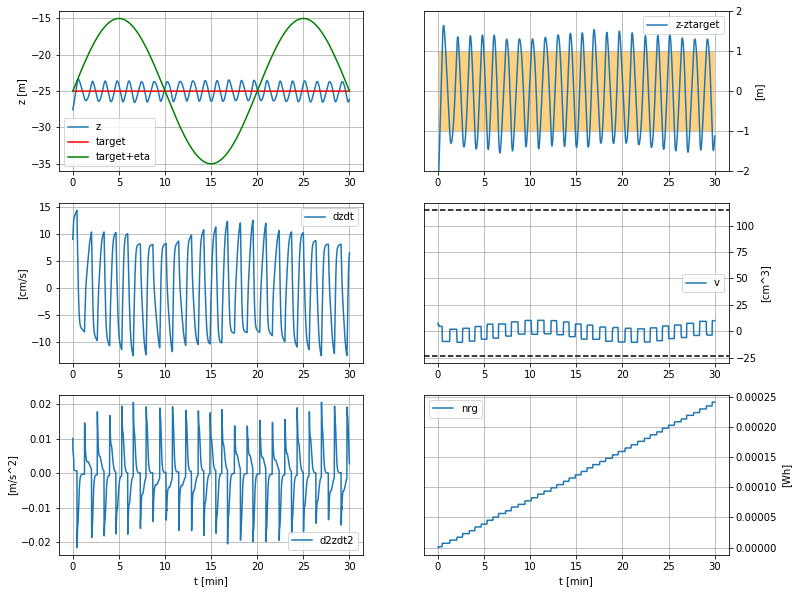

In [18]:
plot_log(f, z_target=z_target, eta=eta)

---

## Moving isopycnals without control

In [19]:
iz = np.argmin(np.abs(z+25.))
v = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz])
f.time_step(w, T=1800., dt_step=.1, dt_store=1., z=-25., w=0., v=v, usepiston=False, eta=eta)

UnboundLocalError: local variable 'x0' referenced before assignment

In [ ]:
plot_log(f, z_target=z_target, eta=eta)